In [1]:
%load_ext autoreload
%autoreload 2
import spike_queries
import pandas as pd
import tqdm
import pickle
import random
import itertools

import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertModel, AutoTokenizer, AutoModel, PreTrainedTokenizerFast
import numpy as np
from typing import List
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from typing import Dict, Tuple
from scipy.spatial.distance import cosine as cosine_distance
from collections import defaultdict
from nltk import ngrams as get_ngrams
from termcolor import colored
import spike_queries


2020-12-13 18:23:53.581 INFO    faiss: Loading faiss with AVX2 support.


In [2]:
with open("queries2.txt", "r") as f:
    queries = f.readlines()
    queries = [l.strip() for l in queries]


FileNotFoundError: [Errno 2] No such file or directory: 'queries2.txt'

In [ ]:
# for i,q in enumerate(queries):
#     try:
#         assert len(q.split("\t")) == 2
#     except:
#         print(i, q, len(q.split("\t")))

In [ ]:
# for i,q in enumerate(queries):
#     a = q.count("arg1:") == q.count("arg2:") == 1
#     if not a:
#         print(i,q)

In [ ]:
# queries2results = defaultdict(list)

In [ ]:
# dataset_name = "covid19"
# num_results = 100
# query_type = "syntactic"

# for i, q_and_id in tqdm.tqdm(enumerate(queries), total = len(queries)):
#     q, id = q_and_id.split("\t")
#     id = int(id)
#     try:
#         df = spike_queries.perform_query(q, dataset_name, num_results, query_type) #previously: word=Hawaii
#         queries2results[id].append(df)
#         time.sleep(2)
#     except Exception as e:
#         print("Error", i+1)
#         print(e)
        
#         continue

In [ ]:
# for id, dfs in queries2results.items():
#     for i,df in enumerate(dfs):
#         print(id, i)
#         queries2results[id][i] = df.dropna(subset=['arg1_first_index',"arg1_last_index","arg2_first_index","arg2_last_index"])

In [ ]:
# len(queries2results)

In [3]:
# with open("queries2results.pickle", "wb") as f:
#      pickle.dump(queries2results, f)

In [4]:
with open("queries2results.pickle", "rb") as f:
    queries2results = pickle.load(f)

In [5]:
# queries2results.keys()

In [6]:
# queries2results_new = dict()
# for k,dfs in queries2results.items():
#     if k == 0: continue
#     queries2results_new[k] = pd.concat(dfs, axis=0)
    
# queries2results = queries2results_new

In [7]:
# df = queries2results[12]
# len(df)
# df2 = df.dropna(subset=['arg1_first_index',"arg1_last_index","arg2_first_index","arg2_last_index"])
# df2["arg2_first_index"]

In [8]:
# ids = set([int(l.split("\t")[-1]) for l in queries])

In [9]:
# data = []
# for id in ids:
#     results = queries2results[id]
#     sents, arg1_first, arg2_first = results["sentence_text"].tolist(), results["arg1_first_index"].tolist(), results["arg2_first_index"].tolist()
#     arg1_last, arg2_last = results["arg1_last_index"].tolist(), results["arg2_last_index"].tolist()
    
#     sents_with_args = []
#     for s,arg1_ind,arg2_ind, arg1_ind_last, arg2_ind_last in zip(sents,arg1_first,arg2_first, arg1_last, arg2_last):
#         s_lst = s.split(" ")
#         if arg1_ind > arg2_ind:
#             arg1_ind, arg2_ind = arg2_ind, arg1_ind
#             arg1_ind_last, arg2_ind_last = arg2_ind_last, arg1_ind_last
#             arg1_str, arg2_str = "ARG2:", "ARG1:"
#         else:
#             arg1_str, arg2_str = "ARG1:", "ARG2:"
#         s_with_args = s_lst[:arg1_ind] + [arg1_str+s_lst[arg1_ind]] + s_lst[arg1_ind+1:arg2_ind] + [arg2_str+s_lst[arg2_ind]] + s_lst[arg2_ind+1:]
#         s_with_args = " ".join(s_with_args)
#         sents_with_args.append({"sent": s_with_args, "start_1": arg1_ind, "start_2": arg2_ind, "end_1": arg1_ind_last,
#                                "end_2": arg2_ind_last})
    
#     max_number_of_pairs = 450
#     pairs = list(itertools.product(sents_with_args, repeat=2))
#     print(id, len(pairs))
#     random.shuffle(pairs)
#     for pair in pairs[:max_number_of_pairs]:
#         data.append({"first": pair[0]["sent"], "second": pair[1]["sent"], "query": q, "first_arg1": (pair[0]["start_1"], pair[0]["end_1"]),
#                     "first_arg2": (pair[0]["start_2"], pair[0]["end_2"]), "second_arg1": (pair[1]["start_1"], pair[1]["end_1"]),
#                    "second_arg2": (pair[1]["start_2"], pair[1]["end_2"])})

In [10]:
# len(data)

In [11]:
# random.shuffle(data)
# data[0]

# with open("data.pickle", "wb") as f:
#     pickle.dump(data, f)

In [12]:
with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
    
with open("data_dev.pickle", "rb") as f:
    data_dev = pickle.load(f)
    
with open("data_train.pickle", "rb") as f:
    data_train = pickle.load(f)
    
#data_train = data_train[1942:]

In [13]:
#data = data[:10000]

In [14]:
# import json

# with open("data.txt", "w") as f:
#     for d in data:
#         first, second = d["first"], d["second"]
#         first_arg1 = d["first_arg1"]
#         first_arg2 = d["first_arg2"]
#         second_arg1 = d["second_arg1"]
#         second_arg2 = d["second_arg2"]
        
#         elems = [first, second, first_arg1, first_arg2, second_arg1, second_arg2]
#         keys = ["first", "second", "first_arg1", "first_arg2"]
        
#         f.write(json.dumps(d) + "\n")
#         #f.write(d["first"] + "\t" + d["second"] + "\t" + d["query"] + "\t" + "-".join(d["first_arg1"])+ "\n")

In [15]:
global count
count = 0
global total
total = 0

print(data[1])

{'first': 'T cells and virus-specific T cells are <<ARG1:essential>> to protect against {{ARG2:virus infection}} , including COVID-19 .', 'second': 'Thus it appears that under conditions in which NK cells are unable to prevent the virus infection , they might participate in the pathogenic process itself .', 'second_with_arguments': 'Thus it appears that under <<ARG1:conditions in which NK cells are unable>> to prevent {{ARG2:the virus infection}} , they might participate in the pathogenic process itself .', 'query_first': '<E|U+C>arg1:white $cells $[l]protect against <E|U+C>arg2:flu $infection', 'query_second': '<E|U+C>arg1:white $cells $[l]prevent the <E|U+C>arg2:flu $infection', 'first_arg1': (7, 7), 'first_arg2': (11, 12), 'second_arg1': (5, 11), 'second_arg2': (14, 16), 'first_arg1_words': ['virus', 'infection'], 'first_arg2_words': ['virus', 'infection'], 'second_arg1_words': ['conditions', 'in', 'which', 'NK', 'cells', 'are', 'unable'], 'second_arg2_words': ['the', 'virus', 'infe

In [16]:
class BertModel(pl.LightningModule):

    def __init__(self, train_dataset: Dataset, dev_dataset: Dataset, batch_size, device: str, mode: str = "eval"):
        
        super().__init__()
        
        self.device_to_use = device
#         config = AutoConfig.from_pretrained('allenai/scibert_scivocab_uncased', output_hidden_states=True)
#         self.tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
#         self.model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased', config=config) 
        config = AutoConfig.from_pretrained('finetuned_model/metric_model3', output_hidden_states=True)
        self.tokenizer = AutoTokenizer.from_pretrained('finetuned_model/metric_model3')
        self.model = AutoModel.from_pretrained('finetuned_model/metric_model3', config=config)   
        
        #config = AutoConfig.from_pretrained('Shauli/RE-metric-model-spike', output_hidden_states=True)
        #self.tokenizer = AutoTokenizer.from_pretrained('Shauli/RE-metric-model-spike')
        #self.model = AutoModel.from_pretrained('Shauli/RE-metric-model-spike', config=config)           
        
        self.train_dataset = train_dataset
        self.dev_dataset = dev_dataset
        self.linear_arg1_1 = torch.nn.Linear(768, 64) #torch.load("finetuned_model/metric_model/linear.pt") #torch.nn.Linear(768, 64)
        self.linear_arg1_1.load_state_dict(torch.load("finetuned_model/metric_model3/linear.pt"))
        self.linear_arg2_1 = torch.nn.Linear(768, 64)
        self.linear_arg1_2 = torch.nn.Linear(768, 64)
        self.linear_arg1_2.load_state_dict(torch.load("finetuned_model/metric_model3/linear2.pt"))

        self.linear_arg2_2 = torch.nn.Linear(768, 64)
        self.linear_is_same_relation = torch.nn.Linear(768, 1)
        self.linear_is_same_relation.load_state_dict(torch.load("finetuned_model/metric_model3/linear_rel_clf.pt"))
        
        self.bce_loss = torch.nn.BCEWithLogitsLoss()
        
        if mode == "eval":
            
            self.model.eval()
        else:
            self.model.train()
        
        for p in self.model.parameters():
            p.requires_grad = True
        for p in self.model.encoder.layer[-1].parameters():
            p.requires_grad = True
        for p in self.model.encoder.layer[-2].parameters():
            p.requires_grad = True       
        for p in self.model.encoder.layer[-3].parameters():
            p.requires_grad = True    
        for p in self.model.encoder.layer[-4].parameters():
            p.requires_grad = True 
            
        for p in self.model.embeddings.parameters():
            p.requires_grad = True
            
        self.linear_arg1_1.requires_grad = True
        self.linear_arg2_1.requires_grad = True
        self.linear_arg1_2.requires_grad = True
        self.linear_arg2_2.requires_grad = True
        
    
        self.train_gen = torch.utils.data.DataLoader(self.train_dataset, batch_size=batch_size, drop_last=False, shuffle=False,
                                                    num_workers = 4)
        self.dev_gen = torch.utils.data.DataLoader(self.dev_dataset, batch_size=batch_size, drop_last=False, shuffle=False,
                                                  num_workers = 4)
        self.acc = None

        
    def tokenize(self, original_sentence: List[str], add_sep = True, add_cls = True) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """

        if add_cls:
            bert_tokens = ["[CLS]"]
        else:
            bert_tokens = []
            
        orig_to_tok_map = {}
        tok_to_orig_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        tok_to_orig_map = {}

        if add_sep:
            bert_tokens.append("[SEP]")
        tok_to_orig_map = get_tok_to_orig_map(orig_to_tok_map, len(original_sentence), len(bert_tokens))        
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(bert_tokens)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device_to_use)

        return (bert_tokens, orig_to_tok_map, tok_to_orig_map, tokens_tensor)
    
    
    def forward(self, x):
        
        outputs = self.model(x)
        states = outputs[0][0] #[seq_len, 768]
        return states
    
    def forward_with_loss_calculation(self, bert_tokens, x, range_sent1, range_sent2, orig_to_tok_map, l, l_tokens,
                                      metric = "l2", n_max = 8, alpha = 0.075, mode = "train", normalize=False, nb=0):
        
        range_sent2[0][0] -= l_tokens
        range_sent2[0][1] -= l_tokens
        range_sent2[1][0] -= l_tokens
        range_sent2[1][1] -= l_tokens
        
        idx_arg1_all, idx_arg2_all, all_ngrams = None, None, None
        
        x_1, x_2 = x[0,:l_tokens], x[0,l_tokens:]
        x_1, x_2 = torch.unsqueeze(x_1,0), torch.unsqueeze(x_2,0)
        
        outputs_1, outputs_2 = self.model(x_1), self.model(x_2)
        states_1 = outputs_1[0][0] #[seq_len, 768]
        states_2 = outputs_2[0][0] #[seq_len, 768]
        is_neg_pred = self.linear_is_same_relation(states_1[0])
        
        if normalize:
            states_1 = states_1 / (torch.norm(states_1, dim = 1, keepdim = True)+1e-8)
            states_2 = states_2 / (torch.norm(states_2, dim = 1, keepdim = True)+1e-8)
        
        states_1 = self.linear_arg1_1(states_1)
        states_2 = self.linear_arg1_2(states_2)
        states = torch.cat([states_1, states_2], dim = 0)        
        
        arg1_sent1, arg2_sent1 = range_sent1
        arg1_sent2, arg2_sent2 = range_sent2
        
        sent1_arg1_vec, sent1_arg2_vec = states_1[arg1_sent1[0]:arg1_sent1[1]].mean(dim=0), states_1[arg2_sent1[0]:arg2_sent1[1]].mean(dim=0)
        sent2_arg1_vec, sent2_arg2_vec = states_2[arg1_sent2[0]:arg1_sent2[1]].mean(dim=0), states_2[arg2_sent2[0]:arg2_sent2[1]].mean(dim=0)        
        
        all_false_ngrams_ranges = get_all_ngrams_spans(len(states_2), [arg1_sent2, arg2_sent2], start_ind = 0,
                                                      n_max = n_max)      
        negatives = [states_2[ngram[0]:ngram[1]].mean(dim=0) for ngram in all_false_ngrams_ranges]
        negatives_arg1 = negatives + [sent2_arg2_vec]
        negatives_arg2 = negatives + [sent2_arg1_vec]
        negatives_arg1 = torch.stack(negatives_arg1).to(self.device_to_use)
        negatives_arg2 = torch.stack(negatives_arg2).to(self.device_to_use)
        

        if mode == "eval":
            all_ngrams = get_all_ngrams_spans(len(states), [], start_ind = l_tokens,
                                                      n_max = n_max)
            ngrams = [states[ngram[0]:ngram[1]].mean(dim=0) for ngram in all_ngrams]
            ngrams = torch.stack(ngrams).to(self.device_to_use)
        
        
        if metric == "l2":
            dists_arg1 = torch.sqrt(((negatives_arg1-sent1_arg1_vec)**2).sum(dim = 1))
            dists_arg2 = torch.sqrt(((negatives_arg2-sent1_arg2_vec)**2).sum(dim = 1))
            dist_arg1_gold = (sent1_arg1_vec - sent2_arg1_vec).norm()
            dist_arg2_gold = (sent1_arg2_vec - sent2_arg2_vec).norm()
            if mode == "eval":
                dist_arg1_all = torch.sqrt(((ngrams-sent1_arg1_vec)**2).sum(dim = 1))
                dist_arg2_all = torch.sqrt(((ngrams-sent1_arg2_vec)**2).sum(dim = 1))
                idx_arg1_all = torch.argsort(dist_arg1_all).detach().cpu().numpy()
                idx_arg2_all = torch.argsort(dist_arg2_all).detach().cpu().numpy()   
        
        idx_arg1 = torch.argsort(dists_arg1).detach().cpu().numpy()
        idx_arg2 = torch.argsort(dists_arg2).detach().cpu().numpy()
        l = max(int(len(negatives)*0.3),1)
        k = random.choice(range(min(len(negatives), 2))) if np.random.random() < 0.5 else random.choice(range(l))

        dist_arg1_argmax = dists_arg1[idx_arg1[k]]
        dist_arg2_argmax = dists_arg2[idx_arg2[k]]
        
        loss_arg1 = torch.max(torch.zeros(1).to(self.device_to_use), dist_arg1_gold - dist_arg1_argmax + alpha)
        loss_arg2 = torch.max(torch.zeros(1).to(self.device_to_use), dist_arg2_gold - dist_arg2_argmax + alpha)
        
        loss = states[0,0:1]**2 #torch.zeros(1).to(self.device)
        loss2_isnan = np.isnan(loss_arg2.detach().cpu().numpy().item())
        loss1_isnan = np.isnan(loss_arg1.detach().cpu().numpy().item())
        if not loss2_isnan:
            loss += loss_arg2
        if not loss1_isnan:
            loss += loss_arg1
        
        if loss1_isnan or loss2_isnan:
            print("ERROR: nan loss", loss1_isnan, loss2_isnan, nb)
            print("loss1_isnan: {}, loss2_isnan: {}".format(loss1_isnan, loss2_isnan))
            print(dist_arg1_argmax,dist_arg2_argmax, dist_arg1_gold, dist_arg2_gold)
            print(l_tokens, x_1.shape, x_2.shape)
            print("=============================================")
            return
        
        global count
        global total
        total += 1                                                      
        #if loss.detach().cpu().numpy().item() < 1e-5:
        if (dist_arg1_gold - dist_arg1_argmax).detach().cpu().numpy().item() < 0 and (dist_arg2_gold - dist_arg2_argmax).detach().cpu().numpy().item() < 0:
            count += 1
        
        return loss, idx_arg1, idx_arg2, idx_arg1_all, idx_arg2_all, all_false_ngrams_ranges, all_ngrams, is_neg_pred
    
        #return loss, np.argsort(dists_arg1+mask_gold_arg1)

             
    def forward_pass(self, x, is_query: bool):
        
        outputs = self.model(x)
        states = outputs[0][0] #[seq_len, 768]
        if is_query:
            states = self.linear_arg1_1(states)
        else:
            states = self.linear_arg1_2(states)
        return states
        
    def forward_with_loss_calculation_inference(self, x_2, sent1_arg1_vec, sent1_arg2_vec, orig_to_tok_map, metric = "l2", n_max = 8, alpha = 0.075, mode = "train", normalize=False, nb=0):
        
        
        idx_arg1_all, idx_arg2_all, all_ngrams = None, None, None
        
        states_2 = self.forward_pass(x_2, is_query = False)
        is_neg_pred = torch.zeros(1)# self.linear_is_same_relation(states_2[0]) 
        
        all_ngrams = get_all_ngrams_spans(len(x_2[0]), [], start_ind = 0,
                                                      n_max = n_max)
        
        ngrams = [states_2[ngram[0]:ngram[1]].mean(dim=0) for ngram in all_ngrams]
        ngrams = torch.stack(ngrams).to(self.device_to_use)
        #all_ngrams = [[n[0]+l_tokens, n[1]+l_tokens] for n in all_ngrams]

        dist_arg1_all = torch.sqrt(((ngrams-sent1_arg1_vec)**2).sum(dim = 1))
        dist_arg2_all = torch.sqrt(((ngrams-sent1_arg2_vec)**2).sum(dim = 1))
        idx_arg1_all = torch.argsort(dist_arg1_all).detach().cpu().numpy()
        idx_arg2_all = torch.argsort(dist_arg2_all).detach().cpu().numpy()   

        return idx_arg1_all, idx_arg2_all, all_ngrams, is_neg_pred

 
    def training_step(self, batch, batch_nb):
        
        sents_concat, idx, l, sent2_with_args, is_negative = batch
        idx = idx.detach().cpu().numpy()[0]
        bert_tokens, orig_to_tok_map, tok_to_orig_map, tokens_tensor = self.tokenize(sents_concat[0].split(" "))             

        
        if not is_negative:
            #print(sents_concat)
            #print("===================================================")
            #print(bert_tokens)
            #print("====================================================")
            #print(orig_to_tok_map)
            l_tokens = len(bert_tokens[:orig_to_tok_map[l.detach().cpu().numpy().item()-1]]) 
            sent1_range_arg1 = get_entity_range_multiword_expression(idx[0][0], orig_to_tok_map)
            sent1_range_arg2 = get_entity_range_multiword_expression(idx[0][1], orig_to_tok_map)
            sent2_range_arg1 = get_entity_range_multiword_expression(idx[1][0], orig_to_tok_map)
            sent2_range_arg2 = get_entity_range_multiword_expression(idx[1][1], orig_to_tok_map)
            range_sent1 = [sent1_range_arg1, sent1_range_arg2]
            range_sent2 = [sent2_range_arg1, sent2_range_arg2]
            loss, _, _, _, _, _, _, is_neg_pred = self.forward_with_loss_calculation(bert_tokens, tokens_tensor, range_sent1, range_sent2, orig_to_tok_map, l, l_tokens, nb = batch_nb)
        else:
            loss = torch.zeros(1).to(self.device)       
            outputs = self.model(tokens_tensor)
            states = outputs[0][0]
            is_neg_pred = self.linear_is_same_relation(states[0])
        
        y = torch.ones(1).to(self.device) if is_negative else torch.zeros(1).to(self.device)
        loss += self.bce_loss(is_neg_pred, y)
        
#         if np.isnan(loss.detach().cpu().numpy().item()) or loss.detach().cpu().numpy().item() > 1e4:
#             print("ERRROR!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
#             print(sents_concat, range_sent1, range_sent2, sent1_idx, sent2_idx)
#             return {"loss": loss*0}

        if total%1000 == 0:
            print("count", count/total)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_nb):

        sents_concat, idx, l, sent2_with_args, is_negative = batch
        if is_negative:
            return {'val_loss': torch.zeros(1).to(self.device)}
        
        idx = idx.detach().cpu().numpy()[0]
        bert_tokens, orig_to_tok_map, tok_to_orig_map, tokens_tensor = self.tokenize(sents_concat[0].split(" "))
        l_tokens = len(bert_tokens[:orig_to_tok_map[l.detach().cpu().numpy().item()-1]]) 
        sent1_range_arg1 = get_entity_range_multiword_expression(idx[0][0], orig_to_tok_map)
        sent1_range_arg2 = get_entity_range_multiword_expression(idx[0][1], orig_to_tok_map)
        sent2_range_arg1 = get_entity_range_multiword_expression(idx[1][0], orig_to_tok_map)
        sent2_range_arg2 = get_entity_range_multiword_expression(idx[1][1], orig_to_tok_map)
        
        range_sent1 = [sent1_range_arg1,sent1_range_arg2]
        range_sent2 = [sent2_range_arg1,sent2_range_arg2]
        loss, _, _, _, _, _, _, is_neg_pred = self.forward_with_loss_calculation(bert_tokens, tokens_tensor, range_sent1, range_sent2, orig_to_tok_map, l, l_tokens)
        
#         print(sents_concat)
#         print("---------------")
#         print(sent2_with_args)
#         print("------------")
#         print(" ".join(bert_tokens[sent1_range_arg1[0]:sent1_range_arg1[1]]))
#         print(" ".join(bert_tokens[sent1_range_arg2[0]:sent1_range_arg2[1]]))
#         print(" ".join(bert_tokens[sent2_range_arg1[0]:sent2_range_arg1[1]]))
#         print(" ".join(bert_tokens[sent2_range_arg2[0]:sent2_range_arg2[1]]))
#         print("============================================")
        #loss, argsort = self.forward_with_loss_calculation(tokens_tensor, sent1_idx, sent2_idx, orig_to_tok_map, tok_to_orig_map, l, l_tokens)

        return {'val_loss': loss}
    
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        print("Loss is {}".format(avg_loss))
        return {'avg_val_loss': avg_loss}
    
    def configure_optimizers(self):
        #return torch.optim.RMSprop(self.parameters())
        #return torch.optim.ASGD(self.parameters())
        return torch.optim.SGD(self.parameters(), lr=0.5*1e-3, momentum=0.6)        
        #return torch.optim.Adam(self.parameters())
    

def evaluate_model(dev_dataset, model, max_ngrams = 2, num_examples = 200):
    
    preds = []
    count = 0
    
    for batch in tqdm.tqdm(dev_dataset):
        if count > num_examples: break
        count += 1

        sents_concat, idx, l, sent2_with_args, is_negative = batch
        if is_negative: continue
        idx = idx.detach().cpu().numpy()
        bert_tokens, orig_to_tok_map, tok_to_orig_map, tokens_tensor = model.tokenize(sents_concat.split(" "))
        l_tokens = len(bert_tokens[:orig_to_tok_map[l-1]]) 
        sent1_range_arg1 = get_entity_range_multiword_expression(idx[0][0], orig_to_tok_map)
        sent1_range_arg2 = get_entity_range_multiword_expression(idx[0][1], orig_to_tok_map)
        sent2_range_arg1 = get_entity_range_multiword_expression(idx[1][0], orig_to_tok_map)
        sent2_range_arg2 = get_entity_range_multiword_expression(idx[1][1], orig_to_tok_map)

        range_sent1 = [sent1_range_arg1,sent1_range_arg2]
        range_sent2 = [sent2_range_arg1,sent2_range_arg2]
                
        idx_arg1_all, idx_arg2_all, all_ngrams = None, None, None
        x = tokens_tensor
        x_1, x_2 = x[0,:l_tokens], x[0,l_tokens:]
        x_1, x_2 = torch.unsqueeze(x_1,0), torch.unsqueeze(x_2,0)
        
        states_1 = model.forward_pass(x_1, is_query = True)
        
        sent1_arg1_vec, sent1_arg2_vec = states_1[sent1_range_arg1[0]:sent1_range_arg1[1]].mean(dim=0), states_1[sent1_range_arg2[0]:sent1_range_arg2[1]].mean(dim=0)
        
        idx_arg1_all, idx_arg2_all, all_ngrams, is_neg_pred = model.forward_with_loss_calculation_inference(x_2, sent1_arg1_vec, sent1_arg2_vec, orig_to_tok_map, mode = "eval", n_max=max_ngrams)
        all_ngrams = [[n[0]+l_tokens, n[1]+l_tokens] for n in all_ngrams]
        is_neg_pred = torch.sigmoid(is_neg_pred).detach().cpu().numpy().item()
        same_relation_score = 1 - is_neg_pred
        preds.append({"sent": sents_concat, "tokens": bert_tokens, "tok2orig": tok_to_orig_map, "orig2tok": orig_to_tok_map,
                     "preds_arg1_tokens": idx_arg1_all, "preds_arg2_tokens": idx_arg2_all, 
                      "all_ngrams": all_ngrams, "gold_arg1_range_tokens": sent2_range_arg1, "gold_arg2_range_tokens": sent2_range_arg2, "same_rel_pred": same_relation_score,
                     "is_negative": is_negative, "l_tokens": l_tokens})
        
    return preds


def get_entity_range(index_orig, orig_to_tok_map):
    
    m = min(orig_to_tok_map.keys())
    if orig_to_tok_map[index_orig] == 1: return (1,2)
    if index_orig == 0: return (1, orig_to_tok_map[index_orig] + 1)
    
    before = index_orig - 1
    tok_range = (orig_to_tok_map[before] + 1, orig_to_tok_map[index_orig] + 1)
    return tok_range

def get_entity_range_multiword_expression(start_and_end, orig_to_tok_map):
    
    start, end = start_and_end
    start_range = get_entity_range(start, orig_to_tok_map)
    end_range = get_entity_range(end, orig_to_tok_map)
    return [start_range[0], end_range[1]]

def get_tok_to_orig_map(orig_to_tok_map, num_words, num_tokens):
    
    ranges = [get_entity_range(i, orig_to_tok_map) for i in range(num_words)]
    tok_to_orig_map = {}
    for i in range(num_words):
        min,max = ranges[i]
        for tok in range(min,max):
            tok_to_orig_map[tok] = i
    
    for tok in range(num_tokens):
        if tok not in tok_to_orig_map:
            tok_to_orig_map[tok] = num_words -1
    
    return tok_to_orig_map
        
def get_all_ngrams_spans(seq_len, forbidden_ranges: List[tuple], start_ind = 0, n_max = 15):
    
    def is_intersecting(ngram, forbidden_ranges):
        
        return [(r[1] > ngram[0] >= r[0]) or(r[1] > ngram[1] >= r[0]) for r in forbidden_ranges]
    
    all_ngrams = []
    for n in range(2,n_max+1):
        ngrams = list(get_ngrams(range(start_ind, seq_len), n))
        all_ngrams.extend(ngrams)
    
    all_ngrams = [(ngram[0], ngram[-1]) for ngram in all_ngrams]
    all_ngrams = [ngram for ngram in all_ngrams if not any(is_intersecting(ngram, forbidden_ranges))]
    return all_ngrams
    
    
def get_prediction(sent1, sent2, model):
    
    l = len(sent1.split(" ")) + 1 
    sent2 = sent2.replace("ARG1:", "").replace("ARG2:", "")
    
    sents_concat = sent1 + " ***** " + sent2
    sent1_arg1 = [i for i,w in enumerate(sent1.split(" ")) if "ARG1:" in w][0]
    sent1_arg2 = [i for i,w in enumerate(sent1.split(" ")) if "ARG2:" in w][0]
    words = sents_concat.split(" ")
    
    bert_tokens, orig_to_tok_map, tok_to_orig_map, tokens_tensor = model.tokenize(sents_concat.split(" "))
    range_arg1 = get_entity_range(sent1_arg1, orig_to_tok_map)
    range_arg2 = get_entity_range(sent1_arg2, orig_to_tok_map)
    
    l_tokens = len(bert_tokens[:orig_to_tok_map[l-1]])    
    outputs = model.model(tokens_tensor)
    states = outputs[0][0] #[seq_len, 768]

    states = states#/torch.norm(states, dim = 1, keepdim = True)
    
    sent1_arg1_vec, sent1_arg2_vec = states[range_arg1[0]:range_arg1[1]].mean(dim=0), states[range_arg2[0]:range_arg2[1]].mean(dim=0)
    
    print("GOLD ARG1, ARG2:", bert_tokens[orig_to_tok_map[sent1_arg1]], bert_tokens[orig_to_tok_map[sent1_arg2]])
    sims_arg1 = (model.linear_arg1_1(states)-model.linear_arg1_2(sent1_arg1_vec)).norm(dim=1)
    sims_arg2 = (model.linear_arg2_1(states)-model.linear_arg2_2(sent1_arg2_vec)).norm(dim=1)

    mask_gold_arg1 = torch.zeros_like(sims_arg1).to(model.device)
    mask_gold_arg2 = torch.zeros_like(sims_arg2).to(model.device)
    mask_gold_arg2[:l_tokens] = 1e6
    mask_gold_arg1[:l_tokens] = 1e6
        
    idx_arg1 = torch.argsort(sims_arg1+mask_gold_arg1).detach().cpu().numpy()
    idx_arg2 = torch.argsort(sims_arg2+mask_gold_arg2).detach().cpu().numpy()
    
    print("all arg1 preds", [words[tok_to_orig_map[idx_arg1[i]]] for i in range(len(idx_arg1))][:7])
    print("---------------------------------------------------")
    print("all arg2 preds", [words[tok_to_orig_map[idx_arg2[i]]] for i in range(len(idx_arg2))][:7])
    print("---------------------------------------------------")
    
    #print(bert_tokens[idx_arg1[-4]], bert_tokens[idx_arg2[-4]])
    
    return
    
    most_sim_arg1, most_sim_arg2 = sims_arg1[idx_arg1[-2]], sims_arg2[idx_arg2[-2]]
    ind_arg1, ind_arg2 = idx_arg1[-2].detach().cpu().numpy().item(), idx_arg2[-2].detach().cpu().numpy().item()
    ind_arg1, ind_arg2 = ind_arg1 + l_tokens, ind_arg2 + l_tokens
    
    return sents_concat, tok_to_orig_map[ind_arg1], tok_to_orig_map[ind_arg2], bert_tokens[ind_arg1], bert_tokens[ind_arg2]

In [18]:
class Dataset(torch.utils.data.Dataset):
    """Simple torch dataset class"""

    def __init__(self, data: List[Dict], device = "cpu"):

        self.data = data
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        with torch.no_grad():
            
            d = self.data[index]
            other = random.choice(range(len(self)))

            if random.random() < 1 or (self.data[other]["query_id"] == d["query_id"]):
                sent1, sent2 = d["first"], d["second"]
                is_negative = False
            else:
                sent1 = d["first"]
                sent2 = self.data[other]["second"] 
                is_negative = True
                
            sent1_arg1, sent1_arg2 = list(d["first_arg1"]), list(d["first_arg2"])
            sent2_arg1, sent2_arg2 = list(d["second_arg1"]), list(d["second_arg2"])            
            l = len(sent1.split(" ")) + 1 
            #sent2_arg1, sent2_arg2 = sent2_arg1 + l, sent2_arg2 + l
            sent2_arg1[0] += l
            sent2_arg1[1] += l
            sent2_arg2[0] += l
            sent2_arg2[1] += l

            sent2 = sent2.replace("ARG1:", "").replace("ARG2:", "")
            sents_concat = sent1 + " ***** " + sent2 #sents_concat.split(" ")[l] is the first token in the 2nd sent
            #create idx tensor. # 1stdim: sents, 2st dim: arg, 3st dim: start and end
            idx = [[[sent1_arg1[0], sent1_arg1[1]], [sent1_arg2[0], sent1_arg2[1]]], [[sent2_arg1[0], sent2_arg1[1]], [sent2_arg2[0], sent2_arg2[1]]] ] 
            sent2_with_args = d["second_with_arguments"]
            return sents_concat, torch.tensor(idx).int(), l, sent2_with_args, is_negative

In [19]:
l = int(0.8 * len(data))
#train_dataset, dev_dataset = Dataset(data[:l], "cpu"), Dataset(data[l:], "cpu")
train_dataset, dev_dataset = Dataset(data_train, "cpu"), Dataset(data_dev, "cpu")

sents_concat, idx, l, sent2_with_args, is_negative = train_dataset[1]
print(sents_concat)
print(idx, idx.shape)
print(is_negative)

T cells and virus-specific T cells are <<ARG1:essential>> to protect against {{ARG2:virus infection}} , including COVID-19 . ***** Thus it appears that under conditions in which NK cells are unable to prevent the virus infection , they might participate in the pathogenic process itself .
tensor([[[ 7,  7],
         [11, 12]],

        [[23, 29],
         [32, 34]]], dtype=torch.int32) torch.Size([2, 2, 2])
False


In [20]:
try:
    del model
except:
    pass
model = BertModel(train_dataset, dev_dataset, 1, "cuda", "train")

In [21]:
# trainer = Trainer(max_epochs=50,min_epochs=1, gpus = 1)
# trainer.fit(model, model.train_gen, model.dev_gen)

In [22]:
data_train[330]

{'first': 'RESULTS : Acidosis limited the cellular consumption of glucose and ATP , causing tumor cells to <<ARG1:enter a metabolically dormant but energetically economic state>> , which promoted tumor cell survival during {{ARG2:glucose deficiency}} .',
 'second': 'How might clonal hematopoiesis in aged populations increase their risk of death from COVID-19 infection ?',
 'second_with_arguments': 'How might <<ARG1:clonal hematopoiesis>> in aged populations increase their risk of death from {{ARG2:COVID-19 infection}} ?',
 'query_first': '<E|U+C>arg1:something, that improved $survival in <E|U+C>arg2:[e=DISEASE|PATHOLOGICAL_FORMATION|CANCER]something',
 'query_second': '<E|U+C>arg1:something can $[w=decrease|prevent|increase]decrease $death rates in <E|U+C>arg2:[e=DISEASE|CANCER|PATHOLOGICAL_FORMATION]something',
 'first_arg1': (16, 23),
 'first_arg2': (31, 32),
 'second_arg1': (2, 3),
 'second_arg2': (13, 14),
 'first_arg1_words': ['glucose', 'deficiency'],
 'first_arg2_words': ['gluco

In [28]:
# #model.to("cpu")
# #model.device = "cpu"
# while True:
#     try:
#         trainer = Trainer(max_nb_epochs=50,min_nb_epochs=1, gpus = 1)
#         trainer.fit(model)
#     except Exception as e:
#         continue

In [29]:
# model.model.save_pretrained("finetuned_model/metric_model3")
# model.tokenizer.save_pretrained("finetuned_model/metric_model3")
# torch.save(model.linear_arg1_1.state_dict(), 'finetuned_model/metric_model3/linear.pt', _use_new_zipfile_serialization = False)
# torch.save(model.linear_arg1_2.state_dict(), 'finetuned_model/metric_model3/linear2.pt', _use_new_zipfile_serialization = False)
# torch.save(model.linear_is_same_relation.state_dict(), 'finetuned_model/metric_model3/linear_rel_clf.pt', _use_new_zipfile_serialization = False)

## model.model.layers

In [23]:
preds = evaluate_model(dev_dataset, model.cuda(), max_ngrams = 8, num_examples = 100)

  1%|          | 101/11650 [00:04<08:26, 22.82it/s]


In [31]:
raise Exception

Exception: 

In [24]:
def pretty_print(sent, idx_arg1, idx_arg2):
    
    sent_lst = sent.split(" ")
    sent = " ".join(sent_lst[:idx_arg1[0]]) + " " + colored(" ".join(sent_lst[idx_arg1[0]:idx_arg1[1]]), "red") + " " + " ".join(sent_lst[idx_arg1[1]:])
    sent_lst = sent.split(" ")
    sent = " ".join(sent_lst[:idx_arg2[0]]) + " " + colored(" ".join(sent_lst[idx_arg2[0]:idx_arg2[1]]), "blue") + " " + " ".join(sent_lst[idx_arg2[1]:])
    return sent

good, bad = 0., 0.

def is_contained(pred, gold):
    return pred[0] >= gold[0] and pred[1] <= gold[1]

for p in preds:
    sent = p["sent"]
    tokens = p["tokens"]
    range_arg1, range_arg2 = p["gold_arg1_range_tokens"], p["gold_arg2_range_tokens"]
    print(range_arg1, range_arg2)
    print(tokens[:p["l_tokens"]])
    print(colored("Is negative: {}".format(p["is_negative"], "black")))
    print("Same relation pred: {}".format(p["same_rel_pred"]))
    print("Gold arg1: {}; Gold arg2: {}".format(" ".join(tokens[range_arg1[0]:range_arg1[1]]), " ".join(tokens[range_arg2[0]:range_arg2[1]])))
    pred_arg1, pred_arg2 = p["preds_arg1_tokens"], p["preds_arg2_tokens"]
    ngram_pred_arg1_idx, ngram_pred_arg2_idx = p["all_ngrams"][pred_arg1[0]], p["all_ngrams"][pred_arg2[0]]
    print("Pred arg1: {}; Pred arg2: {}".format(" ".join(tokens[ngram_pred_arg1_idx[0]:ngram_pred_arg1_idx[1]]),
         " ".join(tokens[ngram_pred_arg2_idx[0]:ngram_pred_arg2_idx[1]])))
    
    arg1_start = p["tok2orig"][ngram_pred_arg1_idx[0]]
    arg1_end = p["tok2orig"][ngram_pred_arg1_idx[1]]
    arg2_start = p["tok2orig"][ngram_pred_arg2_idx[0]]
    arg2_end = p["tok2orig"][ngram_pred_arg2_idx[1]]
    #print(p["preds_arg1_tokens"][:] == p["preds_arg2_tokens"][:])
    print(pretty_print(sent, [arg1_start, arg1_end], [arg2_start, arg2_end]))
    
    
    #if range_arg1[0] == ngram_pred_arg1_idx[0] and range_arg1[1] == ngram_pred_arg1_idx[1] and range_arg2[0] == ngram_pred_arg2_idx[0] and range_arg2[1] == ngram_pred_arg2_idx[1]:
    correct = is_contained(ngram_pred_arg1_idx, range_arg1) and is_contained(ngram_pred_arg2_idx, range_arg2)
    if correct:    
        good += 1
    else:
        bad += 1
        
    print(colored("Correct: {}".format(correct), "green" if correct else "red"))
    print("=================================================================")
print(good / (good + bad))

[62, 63] [56, 57]
['[CLS]', 'interestingly', ',', '<', '<', 'arg', '##1', ':', 'and', '##v', '>', '>', 'may', 'also', 'be', 'shed', 'by', '{', '{', 'arg', '##2', ':', 'humans', '}', '}', 'through', 'other', 'biological', 'fluids', 'such', 'as', 'urine', '[', '136', ']', ',', 'illustrating', 'the', 'particular', 'properties', 'that', 'differentiate', 'this', 'virus', 'from', 'other', 'han', '##ta', '##viruses', '.', '*', '*', '*', '*']
Is negative: False
Same relation pred: 0.5
Gold arg1: energy; Gold arg2: blood
Pred arg1: blood; Pred arg2: energy
Interestingly , <<ARG1:ANDV>> may also be shed by {{ARG2:humans}} through other biological fluids such as urine [ 136 ] , illustrating the particular properties that differentiate this virus from other hantaviruses . ***** Our blood is a valuable reservoir of energy ; the female vector feeds on our blood to aliment its eggs and the microorganism feeds on blood cells to fuel its frantic meiosis .
Correct: False
[80, 81] [72, 75]
['[CLS]', 'the

In [ ]:
ngram_pred_arg1_idx

In [ ]:
k = random.choice(range(100))

sent1 = "The use of 5 % <<ARG1:dextrose>> and sodium bicarbonate is an effective initial treatment for <<ARG2:hyperkalemia>> ."
sent2 = "Cyclosporine is an immunosuppressant and is used to avoid organ transplant rejection ."

with torch.no_grad():
    print(sent1)
    print("-------------------------------")
    print(sent2)
    print("-------------------------------")
    get_prediction(sent1, sent2, model.eval())

print("===================================================")
    
    
sent1 = "Suppose that a fraction <<ARG1:Q>> of all infected individuals is completely isolated and does not transmit the disease to <<ARG2:anyone>> ."
sent2 = "Although the J class is isolated to a negative-pressure room , a few of its members could transmit the virus , by accident , to other people such as healthcare workers ."

with torch.no_grad():
    print(sent1)
    print("-------------------------------")
    print(sent2)
    print("-------------------------------")
    get_prediction(sent1, sent2, model.eval())
    
    
print("===================================================")
    
    
sent1 = "Moreover , the <<ARG1:pathogen>> also spreads to humans through direct <<ARG2:contact with infected poultry>> and contaminated surfaces [ 5 ] ."
sent2 = "The COVID-19 disease can spread in a population through infected symptomatic/asymptomatic individuals who come in contact directly/indirectly [ 4 ] ."

with torch.no_grad():
    print(sent1)
    print("-------------------------------")
    print(sent2)
    print("-------------------------------")
    get_prediction(sent1, sent2, model.eval())
    
    
print("===================================================")
    
    
sent1 = "The low second trimester plasma MBL <<ARG1:level>> is not a risk factor for the development of <<ARG2:preterm birth>> ."
sent2 = "Nevertheless , even 5 - 10 years intervals from the previous gestation do not increase the risk for PE ."

with torch.no_grad():
    print(sent1)
    print("-------------------------------")
    print(sent2)
    print("-------------------------------")
    get_prediction(sent1, sent2, model.eval())
    
    
print("===================================================")
    
    
sent1 = "However , <<ARG1:glucose blood levels>> were reduced and insulin sensitivity was increased in <<ARG2:MTX2>> and MTX4 ."
sent2 = "Both blood glucose and lipid profiles were reduced in the allogenic group [ 9 ] ."

with torch.no_grad():
    print(sent1)
    print("-------------------------------")
    print(sent2)
    print("-------------------------------")
    get_prediction(sent1, sent2, model.eval())
    
    
print("===================================================")
    
    
sent1 = "It seems likely that the prevention and treatment of <<ARG1:AEx of IPF>> must focus on both <<ARG2:disease-specific>> ( e.g. , anti-fi brotic therapies ) and non-disease-specific ( e.g. , vaccination , prevention of stress ) areas ."
sent2 = "Thus , the clinical management of SARS should consider not only antiviral but anti-inflammatory strategies as well ."

with torch.no_grad():
    print(sent1)
    print("-------------------------------")
    print(sent2)
    print("-------------------------------")
    get_prediction(sent1, sent2, model.eval())
    
    
    
print("===================================================")
    
    
sent1 = "The results indicate that supplementation of fish with <<ARG1:rosemary>> could improve the haematological and immunological properties and increase the survival rate after challenge with <<ARG2:S. iniae>> ."
sent2 = "Recent studies have demonstrated that prolonged treatment with EP can ameliorate experimental ulcerative colitis and slow multiple tumor growth ."

with torch.no_grad():
    print(sent1)
    print("-------------------------------")
    print(sent2)
    print("-------------------------------")
    get_prediction(sent1, sent2, model.eval())
    
    
print("===================================================")
    
    
sent1 = "In 2013 , an outbreak of <<ARG1:MERS-CoV>> occurred in the <<ARG2:Middle East>> , including Jordan ( 10 , 11 ) ."
sent2 = "An outbreak of severe acute respiratory syndrome ( SARS ) was detected in Singapore at the beginning of March 2003 ."

with torch.no_grad():
    print(sent1)
    print("-------------------------------")
    print(sent2)
    print("-------------------------------")
    get_prediction(sent1, sent2, model.eval())
    
    
print("===================================================")
    

for i in range(25):

    sent1 = data[i]["first"]
    sent2 = data[i]["second"].replace("ARG1:", "").replace("ARG2:","")
    with torch.no_grad():
        print(sent1)
        print("-------------------------------")
        print(data[i]["second_with_arguments"])
        print("-------------------------------")
        get_prediction(sent1, sent2, model.eval())

In [93]:
dataset_name = "covid19"
num_results = 250
query_type = "syntactic"
import time
query = data_dev[2]["query_first"]

In [94]:
spike_df = spike_queries.perform_query(query, dataset_name, num_results, query_type)

In [179]:
def add_arguments(sent:str, arg1_start, arg1_end, arg2_start, arg2_end):
    
        s_lst = sent.split(" ")
        if arg1_start > arg2_start:
            arg1_start, arg2_start = arg2_start, arg1_start
            arg1_end, arg2_end = arg2_end, arg1_end
            arg1_str, arg2_str = "{{ARG2:", "<<ARG1:"
        else:
            arg1_str, arg2_str = "<<ARG1:", "{{ARG2:"
        
        s_with_args = s_lst[:arg1_start] + [arg1_str] + s_lst[arg1_start:arg1_end+1] + [">>"] + s_lst[arg1_end+1:arg2_start] + [arg2_str] + s_lst[arg2_start:arg2_end+1] + ["}}"] +s_lst[arg2_end+1:]  
        #s_with_args = s_lst[:arg1_start] + [arg1_str+s_lst[arg1_ind]] + s_lst[arg1_ind+1:arg2_ind] + [arg2_str+s_lst[arg2_ind]] + s_lst[arg2_ind+1:]
        s_with_args = " ".join(s_with_args).replace("ARG1: ", "ARG1:").replace("ARG2: ", "ARG2:")
        s_with_args = s_with_args.replace(" >>", ">>").replace(" }}", "}}")
        return s_with_args
    
def prepare_example(sent1, arg1_sent1, arg2_sent1):

            sent1 = add_arguments(sent1, arg1_sent1[0], arg1_sent1[1], arg2_sent1[0], arg2_sent1[1])
            idx = [[[arg1_sent1[0], arg1_sent1[1]], [arg2_sent1[0], arg2_sent1[1]]], [[0, 1], [0, 1]]] 
            return sent1, np.array(idx)

def get_query_rep(spike_df, model, k = 5):

    query_sents = spike_df["sentence_text"].tolist()[:k]
    query_arg1_starts = spike_df["arg1_first_index"][:k]
    query_arg1_ends = spike_df["arg1_last_index"][:k]
    query_arg2_starts = spike_df["arg2_first_index"][:k]
    query_arg2_ends = spike_df["arg2_last_index"][:k]
    
    arg1_vecs, arg2_vecs = [], []
    
    for i in range(min(len(spike_df), k)):
    
        sent1 = query_sents[i] + " ****" # use first query in all examples.
        arg1_sent1 = [query_arg1_starts[i], query_arg1_ends[i]]
        arg2_sent1 = [query_arg2_starts[i], query_arg2_ends[i]]
        sent1, idx = prepare_example(sent1, arg1_sent1, arg2_sent1)
        bert_tokens, orig_to_tok_map, tok_to_orig_map, tokens_tensor = model.tokenize(sent1.split(" "), add_sep = False, add_cls = True)
        
        with torch.no_grad():
            x = torch.unsqueeze(tokens_tensor,0)
            states = model.forward_pass(tokens_tensor, is_query = True)
            sent1_range_arg1 = get_entity_range_multiword_expression(idx[0][0], orig_to_tok_map)
            sent1_range_arg2 = get_entity_range_multiword_expression(idx[0][1], orig_to_tok_map)       
            sent1_arg1_vec, sent1_arg2_vec = states[sent1_range_arg1[0]:sent1_range_arg1[1]].mean(dim=0), states[sent1_range_arg2[0]:sent1_range_arg2[1]].mean(dim=0)
            arg1_vecs.append(sent1_arg1_vec)
            arg2_vecs.append(sent1_arg2_vec)
        
    
    arg1_mean = torch.stack(arg1_vecs, dim = 0).mean(dim = 0)
    arg2_mean = torch.stack(arg2_vecs, dim = 0).mean(dim = 0)
    
    return arg1_mean, arg2_mean

def evaluate_model_df(spike_df, sents, model, k, max_ngrams = 8, num_examples = 200):
    
    
    arg1_mean, arg2_mean = get_query_rep(spike_df, model, k = k)
    
    preds = []
    count = 0
    
    for i in range(len(sents)):
               
        with torch.no_grad():
            bert_tokens, orig_to_tok_map, tok_to_orig_map, tokens_tensor = model.tokenize(sents[i].split(" "), add_sep = True, add_cls = False)
            x = tokens_tensor
            
            idx_arg1_all, idx_arg2_all, all_ngrams, is_neg_pred = model.forward_with_loss_calculation_inference(x, arg1_mean, arg2_mean, orig_to_tok_map, mode = "eval", n_max=max_ngrams)
        preds.append({"sent": sents_concat, "tokens": bert_tokens, "tok2orig": tok_to_orig_map, "orig2tok": orig_to_tok_map,
                     "preds_arg1_tokens": idx_arg1_all, "preds_arg2_tokens": idx_arg2_all,
                      "all_ngrams": all_ngrams})
        
    return preds

In [190]:
k_vals = [1,2,3,5,10,20,25,50]
k2acc = {}

for k in k_vals:
    good, bad = 0., 0
    
    for i in tqdm.tqdm_notebook(range(200)):
        d = data_dev[i]
        query = d["query_first"]
        #print(d)
        spike_df = spike_queries.perform_query(query, dataset_name, k, query_type)
        spike_df[spike_df["sentence_text"] != d["second"]]
        p = evaluate_model_df(spike_df,  [d["second"]], model, k=k)[0]
    
        range_arg1, range_arg2 = d["second_arg1"], d["second_arg2"]
        sent2_range_arg1 = get_entity_range_multiword_expression(range_arg1, p["orig2tok"])
        sent2_range_arg2 = get_entity_range_multiword_expression(range_arg2, p["orig2tok"])
    
        pred_arg1, pred_arg2 = p["preds_arg1_tokens"], p["preds_arg2_tokens"]
        ngram_pred_arg1_idx, ngram_pred_arg2_idx = p["all_ngrams"][pred_arg1[0]], p["all_ngrams"][pred_arg2[0]]
        correct = is_contained(ngram_pred_arg1_idx, sent2_range_arg1) and is_contained(ngram_pred_arg2_idx, sent2_range_arg2)
        if correct:    
            good += 1
        else:
            bad += 1
          
          
        arg1_start = p["tok2orig"][ngram_pred_arg1_idx[0]]
        arg1_end = p["tok2orig"][ngram_pred_arg1_idx[1]]
        arg2_start = p["tok2orig"][ngram_pred_arg2_idx[0]]
        arg2_end = p["tok2orig"][ngram_pred_arg2_idx[1]]
        #print(p["preds_arg1_tokens"][:] == p["preds_arg2_tokens"][:])
        print(pretty_print(d["second"], [arg1_start, arg1_end], [arg2_start, arg2_end]))
        print(good / (good + bad + 1e-9))      
        print("===============================")
        #print(good / (good + bad + 1e-8))
    
    k2acc[k] = good / (good + bad + 1e-9)

/home/shauli/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Our blood is a valuable reservoir of energy ; the female vector feeds on our blood to aliment its eggs and the microorganism feeds on blood cells to fuel its frantic meiosis .
0.0
Even though , the body weight index and lung weight index did not change significantly ( Fig. 1c and d , P > 0.05 ) , the lung edema , a typical symptom of inflammation in lung injury [ 17 ] , reduced obviously in LPS-treated MAPK4 −/− mice compared with that in LPS-treated WT mice ( Fig. 1e , P < 0.05 ) .
0.0
In general , available SARS-CoV-2 oligonucleotides diverge from other human coronaviruses by several positions , and therefore are unlikely to cause false-positives .
0.3333333332222222
Fifty-five percent of participants believed that a fecal-oral route of transmission of COVID-19 infection is possible and 9.7 % believed the fecal-oral route is not possible , and the remainder ( 35.4 % ) were unsure .
0.499999999875
Deterioration of the parent-child relationship , less physical activity , irregular work

This is suspected for the HCoV OC43 that may have evolved from the bovine coronavirus , which is responsible for gastrointestinal infections in cattle [ 64 ] .
0.2571428571355102
Kohl et al. [ 25 ] carried out genome pyrosequencing of bat adenovirus 2 and found there was an interspecies transmission during evolution of Canine adenovirus 1 and 2 from Vespertilionid bat adenovirus .
0.27777777777006174
However , the distribution of Fv1 in Muroidea indicates that it was inserted approximately 45 to 55 million years ago , which dates to a time point after the divergence of Chiroptera from Rodentia over 70 million years ago ( 36 ) .
0.29729729728926224
Emerging evidence suggests that obesity is a strong risk factor for severe complications , hospitalisation and death from the coronavirus disease 2019 ( COVID-19 ) ( 2 ) .
0.2894736842029086
The benefit of this approach is that it uses standard catheter laboratory equipment and thus poses no greater safety risk to the patient .
0.307692307684

For example , are those who would choose to attend a stadium concert during a pandemic more or less likely to participate in protective actions that lower their overall risk of virus infection or of virus transmission ?
0.3333333333282828
 In-vivo studies will be required to optimize these strategies for inducing immunity against SARS-CoV-2 .
0.32835820895032297
Phytochemicals ( i.e. , molecules derived from plants and often adopted for food or traditional medicine purposes ) are emerging in the very recent literature as an alternative source of investigation for the inhibition of SARS-CoV-2 Mpro .
0.3235294117599481
RESULTS The first onset symptom of the 27 cases is high fever accompany with toxic symptom such as muscular soreness , headache , etc .
0.31884057970552404
Animal studies have proved that the glucose tolerance factor ( GTF ) , a dietary agent extracted from yeast , functions as a putative insulin mimetic to lower blood glucose and lipid concentrations .
0.3142857142812245


Almost all children with ILI associated with RSV experienced a new or worsening cough ( 96 % ) , which is a common symptom of lower respiratory tract infection .
0.27835051546104794
Wild pigs infected with ASFV show no signs of the disease , with low viremia titers .
0.2755102040788213
Specifically , we aimed to quantitatively separate dysmetria , a cardinal sign of ataxia , from tremor in Essential Tremor ( ET ) .
0.282828282825426
The health carehealthcare cost per SARS patient in Beijing was 17,150 CNY ( 1,886USD ) while886 USD ) , whereas the average medical cost per H7N9 patient was 99,691 CNY ( 15,951 USD ) because of the higher fatality rate of H7N9 patients and use of more expensive modern medical device had been useddevices .
0.2799999999972
Incorrect timing of antibiotic prophylaxis was the key risk factor for wound infections .
0.28712871286844427
 Lymphopenia was identified as a risk factor for death in the previous study , but eosinopenia was not mentioned .
0.294117647055

The mean therapy costs before and after GB were NT$421.03 ± 100.03 and NT $ 2,217.03 ± 672.20 , respectively .
0.2923076923054438
 Amikacin , the drug obtained with the fourth-lowest value of grid score formed hydrogen bonds with CYS 145 , ASN 142 and MET 165 .
0.2900763358756483
Ref . [ 2 ] Some patients may have sore throat , rhinorrhea , headache and confusion a few days before the onset of fever , indicating that fever is a critical symptom , but not the only initial manifestation of infection .
0.2954545454523072
Recent observational studies suggested obesity to be a possible risk factor for COVID-19 disease in the wake of the coronavirus ( SARS-CoV-2 ) infection .
0.29323308270456216
A meta-analysis by Mulder et al. ( 2018 ) on risk factors for child neglect also concluded that children 's age is not a risk factor for child neglect .
0.29850746268433953
The positive effect of IF in triggering autophagy , and the way how autophagy triggers the innate and adaptive immunity against 

Brefeldin A ( BFA ) is a small molecule originally isolated from fungi that has been demonstrated to inhibit the Arf1 exchange factor , GBF1 [ 123 ] .
0.29268292682748365
Brief Introduction of the Origin of CQ and HCQ CQ was originated from quinine , which was short-acting alkaloid drug extracted from cinchona bark and was the first drug used widely for malaria from the 19th century ( Ross , 1918 ) .
0.29696969696789716
COVID-19 is mostly a respiratory disease , and the main transmission is through droplets and aerosolization , and therefore a policy of universal respiratory precautions in the OR is encouraged 16 and includes the following key points :
0.2951807228897881
Vomiting is the first sign of gastrointestinal disease in most ferrets , but it may go unnoticed by some owners because it subsides within hours [ 44 ] .
0.29341317365093766
The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes , so it 's im

Several episodes of reverse transmission of the virus from infected humans to pigs later proved that pigs will demonstrate very mild flu like symptoms on infection before recovery and can sustain the virus within the flock ( Howden et al. , 2009 ; Pereda et al. , 2010 ; Rith et al. , 2013 ; Song et al. , 2010 ; Sreta et al. , 2010 ) .
0.2893401015213739
Genetic testing is mandatory and can add important information such as risk of malignancy .
0.28787878787733395
Clinically the disease in cervids is manifested initially by changes in behavior not commonly observed in free-ranging cervids , and the major manifestation is a marked fall in body condition .
0.28643216080258077
Moreover , the presence of a CVC is not only a risk factor for S. maltophilia bacteremia but also an important source of bacteremia [ 7 ] .
0.284999999998575



Our blood is a valuable reservoir of energy ; the female vector feeds on our blood to aliment its eggs and the microorganism feeds on blood cells to fuel its frantic meiosis .
0.0
Even though , the body weight index and lung weight index did not change significantly ( Fig. 1c and d , P > 0.05 ) , the lung edema , a typical symptom of inflammation in lung injury [ 17 ] , reduced obviously in LPS-treated MAPK4 −/− mice compared with that in LPS-treated WT mice ( Fig. 1e , P < 0.05 ) .
0.49999999975
In general , available SARS-CoV-2 oligonucleotides diverge from other human coronaviruses by several positions , and therefore are unlikely to cause false-positives .
0.6666666664444444
Fifty-five percent of participants believed that a fecal-oral route of transmission of COVID-19 infection is possible and 9.7 % believed the fecal-oral route is not possible , and the remainder ( 35.4 % ) were unsure .
0.7499999998125
Deterioration of the parent-child relationship , less physical activity , irr

This is suspected for the HCoV OC43 that may have evolved from the bovine coronavirus , which is responsible for gastrointestinal infections in cattle [ 64 ] .
0.31428571427673474
Kohl et al. [ 25 ] carried out genome pyrosequencing of bat adenovirus 2 and found there was an interspecies transmission during evolution of Canine adenovirus 1 and 2 from Vespertilionid bat adenovirus .
0.3333333333240741
However , the distribution of Fv1 in Muroidea indicates that it was inserted approximately 45 to 55 million years ago , which dates to a time point after the divergence of Chiroptera from Rodentia over 70 million years ago ( 36 ) .
0.32432432431555885
Emerging evidence suggests that obesity is a strong risk factor for severe complications , hospitalisation and death from the coronavirus disease 2019 ( COVID-19 ) ( 2 ) .
0.3157894736759003
The benefit of this approach is that it uses standard catheter laboratory equipment and thus poses no greater safety risk to the patient .
0.333333333324

For example , are those who would choose to attend a stadium concert during a pandemic more or less likely to participate in protective actions that lower their overall risk of virus infection or of virus transmission ?
0.3484848484795684
In-vivo studies will be required to optimize these strategies for inducing immunity against SARS-CoV-2 .
0.3432835820844286
Phytochemicals ( i.e. , molecules derived from plants and often adopted for food or traditional medicine purposes ) are emerging in the very recent literature as an alternative source of investigation for the inhibition of SARS-CoV-2 Mpro .
0.338235294112673
RESULTS The first onset symptom of the 27 cases is high fever accompany with toxic symptom such as muscular soreness , headache , etc .
0.3333333333285024
Animal studies have proved that the glucose tolerance factor ( GTF ) , a dietary agent extracted from yeast , functions as a putative insulin mimetic to lower blood glucose and lipid concentrations .
0.3428571428522449
Rece

Almost all children with ILI associated with RSV experienced a new or worsening cough ( 96 % ) , which is a common symptom of lower respiratory tract infection .
0.2886597938114571
Wild pigs infected with ASFV show no signs of the disease , with low viremia titers .
0.28571428571137025
Specifically , we aimed to quantitatively separate dysmetria , a cardinal sign of ataxia , from tremor in Essential Tremor ( ET ) .
0.292929292926334
The health carehealthcare cost per SARS patient in Beijing was 17,150 CNY ( 1,886USD ) while886 USD ) , whereas the average medical cost per H7N9 patient was 99,691 CNY ( 15,951 USD ) because of the higher fatality rate of H7N9 patients and use of more expensive modern medical device had been useddevices .
0.28999999999709997
Incorrect timing of antibiotic prophylaxis was the key risk factor for wound infections .
0.29702970296735615
 Lymphopenia was identified as a risk factor for death in the previous study , but eosinopenia was not mentioned .
0.30392156

The mean therapy costs before and after GB were  NT$421.03 ± 100.03 and NT $ 2,217.03 ± 672.20 , respectively .
0.31538461538218937
Amikacin , the drug obtained with the fourth-lowest value of grid score formed hydrogen bonds with CYS 145 , ASN 142 and MET 165 .
0.3129770992342521
Ref . [ 2 ] Some patients may have sore throat , rhinorrhea , headache and confusion a few days before the onset of fever , indicating that fever is a critical symptom , but not the only initial manifestation of infection .
0.3181818181794077
Recent observational studies suggested obesity to be a possible risk factor for COVID-19 disease in the wake of the coronavirus ( SARS-CoV-2 ) infection .
0.3157894736818362
A meta-analysis by Mulder et al. ( 2018 ) on risk factors for child neglect also concluded that children 's age is not a risk factor for child neglect .
0.320895522385665
The positive effect of IF in triggering autophagy , and the way how autophagy triggers the innate and adaptive immunity against vi

Brefeldin A ( BFA ) is a small molecule originally isolated from fungi that has been demonstrated to inhibit the Arf1 exchange factor , GBF1 [ 123 ] .
0.317073170729774
Brief Introduction of the Origin of CQ and HCQ CQ was originated from quinine , which was short-acting alkaloid drug extracted from cinchona bark and was the first drug used widely for malaria from the 19th century ( Ross , 1918 ) .
0.31515151514960515
 COVID-19 is mostly a respiratory disease , and the main transmission is through droplets and aerosolization , and therefore a policy of universal respiratory precautions in the OR is encouraged 16 and includes the following key points :
0.3192771084318116
Vomiting is the first sign of gastrointestinal disease in most ferrets , but it may go unnoticed by some owners because it subsides within hours [ 44 ] .
0.3173652694591775
The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes , so it 's impo

Several episodes of reverse transmission of the virus from infected humans to pigs later proved that pigs will demonstrate very mild flu like symptoms on infection before recovery and can sustain the virus within the flock ( Howden et al. , 2009 ; Pereda et al. , 2010 ; Rith et al. , 2013 ; Song et al. , 2010 ; Sreta et al. , 2010 ) .
0.29949238578528176
Genetic testing is mandatory and can add important information such as risk of malignancy .
0.29797979797829305
Clinically the disease in cervids is manifested initially by changes in behavior not commonly observed in free-ranging cervids , and the major manifestation is a marked fall in body condition .
0.29648241205881165
Moreover , the presence of a CVC is not only a risk factor for S. maltophilia bacteremia but also an important source of bacteremia [ 7 ] .
0.2999999999985



Our blood is a valuable reservoir of energy ; the female vector feeds on our blood to aliment its eggs and the microorganism feeds on blood cells to fuel its frantic meiosis .
0.0
Even though , the body weight index and lung weight index did not change significantly ( Fig. 1c and d , P > 0.05 ) , the lung edema , a typical symptom of inflammation in lung injury [ 17 ] , reduced obviously in LPS-treated MAPK4 −/− mice compared with that in LPS-treated WT mice ( Fig. 1e , P < 0.05 ) .
0.49999999975
In general , available SARS-CoV-2 oligonucleotides diverge from other human coronaviruses by several positions , and therefore are unlikely to cause false-positives .
0.6666666664444444
Fifty-five percent of participants believed that a fecal-oral route of transmission of COVID-19 infection is possible and 9.7 % believed the fecal-oral route is not possible , and the remainder ( 35.4 % ) were unsure .
0.7499999998125
Deterioration of the parent-child relationship , less physical activity , irr

This is suspected for the HCoV OC43 that may have evolved from the bovine coronavirus , which is responsible for gastrointestinal infections in cattle [ 64 ] .
0.28571428570612245
Kohl et al. [ 25 ] carried out genome pyrosequencing of bat adenovirus 2 and found there was an interspecies transmission during evolution of Canine adenovirus 1 and 2 from Vespertilionid bat adenovirus .
0.3055555555470679
However , the distribution of Fv1 in Muroidea indicates that it was inserted approximately 45 to 55 million years ago , which dates to a time point after the divergence of Chiroptera from Rodentia over 70 million years ago ( 36 ) .
0.32432432431555885
Emerging evidence suggests that obesity is a strong risk factor for severe complications , hospitalisation and death from the coronavirus disease 2019 ( COVID-19 ) ( 2 ) .
0.3157894736759003
The benefit of this approach is that it uses standard catheter laboratory equipment and thus poses no greater safety risk to the patient .
0.333333333324

For example , are those who would choose to attend a stadium concert during a pandemic more or less likely to participate in protective actions that lower their overall risk of virus infection or of virus transmission ?
0.3484848484795684
In-vivo studies will be required to optimize these strategies for inducing immunity against SARS-CoV-2 .
0.3582089552185342
Phytochemicals ( i.e. , molecules derived from plants and often adopted for food or traditional medicine purposes ) are emerging in the very recent literature as an alternative source of investigation for the inhibition of SARS-CoV-2 Mpro .
0.3529411764653979
RESULTS The first onset symptom of the 27 cases is high fever accompany with toxic symptom such as muscular soreness , headache , etc .
0.34782608695148076
Animal studies have proved that the glucose tolerance factor ( GTF ) , a dietary agent extracted from yeast , functions as a putative insulin mimetic to lower blood glucose and lipid concentrations .
0.35714285713775507
R

Almost all children with ILI associated with RSV experienced a new or worsening cough ( 96 % ) , which is a common symptom of lower respiratory tract infection .
0.3092783505122755
Wild pigs infected with ASFV show no signs of the disease , with low viremia titers .
0.3061224489764681
Specifically , we aimed to quantitatively separate dysmetria , a cardinal sign of ataxia , from tremor in Essential Tremor ( ET ) .
0.3030303030272421
The health carehealthcare cost per SARS patient in Beijing was 17,150 CNY ( 1,886USD ) while886 USD ) , whereas the average medical cost per H7N9 patient was 99,691 CNY ( 15,951 USD ) because of the higher fatality rate of H7N9 patients and use of more expensive modern medical device had been useddevices .
0.299999999997
Incorrect timing of antibiotic prophylaxis was the key risk factor for wound infections .
0.306930693066268
 Lymphopenia was identified as a risk factor for death in the previous study , but eosinopenia was not mentioned .
0.313725490193002

The mean therapy costs before and after GB were NT$421.03 ± 100.03 and NT $ 2,217.03 ± 672.20 , respectively .
0.3076923076899409
Amikacin , the drug obtained with the fourth-lowest value of grid score formed hydrogen bonds with CYS 145 , ASN 142 and MET 165 .
0.30534351144805083
Ref . [ 2 ] Some patients may have sore throat , rhinorrhea , headache and confusion a few days before the onset of fever , indicating that fever is a critical symptom , but not the only initial manifestation of infection .
0.31060606060370755
Recent observational studies suggested obesity to be a possible risk factor for COVID-19 disease in the wake of the coronavirus ( SARS-CoV-2 ) infection .
0.30827067668941155
A meta-analysis by Mulder et al. ( 2018 ) on risk factors for child neglect also concluded that children 's age is not a risk factor for child neglect .
0.3134328358185565
The positive effect of IF in triggering autophagy , and the way how autophagy triggers the innate and adaptive immunity against 

Brefeldin A ( BFA ) is a small molecule originally isolated from fungi that has been demonstrated to inhibit the Arf1 exchange factor , GBF1 [ 123 ] .
0.3048780487786288
Brief Introduction of the Origin of CQ and HCQ CQ was originated from quinine , which was short-acting alkaloid drug extracted from cinchona bark and was the first drug used widely for malaria from the 19th century ( Ross , 1918 ) .
0.30909090908903586
 COVID-19 is mostly a respiratory disease , and the main transmission is through droplets and aerosolization , and therefore a policy of universal respiratory precautions in the OR is encouraged 16 and includes the following key points :
0.31325301204630573
Vomiting is the first sign of gastrointestinal disease in most ferrets , but it may go unnoticed by some owners because it subsides within hours [ 44 ] .
0.31137724550711754
The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes , so it 's i

Several episodes of reverse transmission of the virus from infected humans to pigs later proved that pigs will demonstrate very mild flu like symptoms on infection before recovery and can sustain the virus within the flock ( Howden et al. , 2009 ; Pereda et al. , 2010 ; Rith et al. , 2013 ; Song et al. , 2010 ; Sreta et al. , 2010 ) .
0.31472081218114356
Genetic testing is mandatory and can add important information such as risk of malignancy .
0.3131313131297317
Clinically the disease in cervids is manifested initially by changes in behavior not commonly observed in free-ranging cervids , and the major manifestation is a marked fall in body condition .
0.311557788943158
Moreover , the presence of a CVC is not only a risk factor for S. maltophilia bacteremia but also an important source of bacteremia [ 7 ] .
0.31499999999842504



Our blood is a valuable reservoir of energy ; the female vector feeds on our blood to aliment its eggs and the microorganism feeds on blood cells to fuel its frantic meiosis .
0.0
Even though , the body weight index and lung weight index did not change significantly ( Fig. 1c and d , P > 0.05 ) , the lung edema , a typical symptom of inflammation in lung injury [ 17 ] , reduced obviously in LPS-treated MAPK4 −/− mice compared with that in LPS-treated WT mice ( Fig. 1e , P < 0.05 ) .
0.49999999975
In general , available SARS-CoV-2 oligonucleotides diverge from other human coronaviruses by several positions , and therefore are unlikely to cause false-positives .
0.6666666664444444
Fifty-five percent of participants believed that a fecal-oral route of transmission of COVID-19 infection is possible and 9.7 % believed the fecal-oral route is not possible , and the remainder ( 35.4 % ) were unsure .
0.7499999998125
Deterioration of the parent-child relationship , less physical activity , irr

This is suspected for the HCoV OC43 that may have evolved from the bovine coronavirus , which is responsible for gastrointestinal infections in cattle [ 64 ] .
0.31428571427673474
Kohl et al. [ 25 ] carried out genome pyrosequencing of bat adenovirus 2 and found there was an interspecies transmission during evolution of Canine adenovirus 1 and 2 from Vespertilionid bat adenovirus .
0.3333333333240741
However , the distribution of Fv1 in Muroidea indicates that it was inserted approximately 45 to 55 million years ago , which dates to a time point after the divergence of Chiroptera from Rodentia over 70 million years ago ( 36 ) .
0.32432432431555885
Emerging evidence suggests that obesity is a strong risk factor for severe complications , hospitalisation and death from the coronavirus disease 2019 ( COVID-19 ) ( 2 ) .
0.3157894736759003
The benefit of this approach is that it uses standard catheter laboratory equipment and thus poses no greater safety risk to the patient .
0.333333333324

For example , are those who would choose to attend a stadium concert during a pandemic more or less likely to participate in protective actions that lower their overall risk of virus infection or of virus transmission ?
0.30303030302571166
In-vivo studies will be required to optimize these strategies for inducing immunity against SARS-CoV-2 .
0.2985074626821118
Phytochemicals ( i.e. , molecules derived from plants and often adopted for food or traditional medicine purposes ) are emerging in the very recent literature as an alternative source of investigation for the inhibition of SARS-CoV-2 Mpro .
0.2941176470544983
RESULTS The first onset symptom of the 27 cases is high fever accompany with toxic symptom such as muscular soreness , headache , etc .
0.2898550724595673
Animal studies have proved that the glucose tolerance factor ( GTF ) , a dietary agent extracted from yeast , functions as a putative insulin mimetic to lower blood glucose and lipid concentrations .
0.29999999999571425
R

Almost all children with ILI associated with RSV experienced a new or worsening cough ( 96 % ) , which is a common symptom of lower respiratory tract infection .
0.2577319587602296
Wild pigs infected with ASFV show no signs of the disease , with low viremia titers .
0.25510204081372345
Specifically , we aimed to quantitatively separate dysmetria , a cardinal sign of ataxia , from tremor in Essential Tremor ( ET ) .
0.25252525252270175
The health carehealthcare cost per SARS patient in Beijing was 17,150 CNY ( 1,886USD ) while886 USD ) , whereas the average medical cost per H7N9 patient was 99,691 CNY ( 15,951 USD ) because of the higher fatality rate of H7N9 patients and use of more expensive modern medical device had been useddevices .
0.2499999999975
Incorrect timing of antibiotic prophylaxis was the key risk factor for wound infections .
0.25742574257170864
 Lymphopenia was identified as a risk factor for death in the previous study , but eosinopenia was not mentioned .
0.2647058823

The mean therapy costs before and after GB were NT$421.03 ± 100.03 and NT $ 2,217.03 ± 672.20 , respectively .
0.2538461538442012
Amikacin , the drug obtained with the fourth-lowest value of grid score formed hydrogen bonds with CYS 145 , ASN 142 and MET 165 .
0.25190839694464195
Ref . [ 2 ] Some patients may have sore throat , rhinorrhea , headache and confusion a few days before the onset of fever , indicating that fever is a critical symptom , but not the only initial manifestation of infection .
0.25757575757380624
Recent observational studies suggested obesity to be a possible risk factor for COVID-19 disease in the wake of the coronavirus ( SARS-CoV-2 ) infection .
0.2556390977424388
A meta-analysis by Mulder et al. ( 2018 ) on risk factors for child neglect also concluded that children 's age is not a risk factor for child neglect .
0.2611940298487971
The positive effect of IF in triggering autophagy , and the way how autophagy triggers the innate and adaptive immunity against v

Brefeldin A ( BFA ) is a small molecule originally isolated from fungi that has been demonstrated to inhibit the Arf1 exchange factor , GBF1 [ 123 ] .
0.2621951219496208
Brief Introduction of the Origin of CQ and HCQ CQ was originated from quinine , which was short-acting alkaloid drug extracted from cinchona bark and was the first drug used widely for malaria from the 19th century ( Ross , 1918 ) .
0.2666666666650505
COVID-19 is mostly a respiratory disease , and the main transmission is through droplets and aerosolization , and therefore a policy of universal respiratory precautions in the OR is encouraged 16 and includes the following key points :
0.26506024096225866
Vomiting is the first sign of gastrointestinal disease in most ferrets , but it may go unnoticed by some owners because it subsides within hours [ 44 ] .
0.2634730538906379
The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes , so it 's impo

Several episodes of reverse transmission of the virus from infected humans to pigs later proved that pigs will demonstrate very mild flu like symptoms on infection before recovery and can sustain the virus within the flock ( Howden et al. , 2009 ; Pereda et al. , 2010 ; Rith et al. , 2013 ; Song et al. , 2010 ; Sreta et al. , 2010 ) .
0.2538071065976964
Genetic testing is mandatory and can add important information such as risk of malignancy .
0.2525252525239772
Clinically the disease in cervids is manifested initially by changes in behavior not commonly observed in free-ranging cervids , and the major manifestation is a marked fall in body condition .
0.2512562814057726
Moreover , the presence of a CVC is not only a risk factor for S. maltophilia bacteremia but also an important source of bacteremia [ 7 ] .
0.254999999998725



Our blood is a valuable reservoir of energy ; the female vector feeds on our blood to aliment its eggs and the microorganism feeds on blood cells to fuel its frantic meiosis .
0.0
Even though , the body weight index and lung weight index did not change significantly ( Fig. 1c and d , P > 0.05 ) , the lung edema , a typical symptom of inflammation in lung injury [ 17 ] , reduced obviously in LPS-treated MAPK4 −/− mice compared with that in LPS-treated WT mice ( Fig. 1e , P < 0.05 ) .
0.49999999975
In general , available SARS-CoV-2 oligonucleotides diverge from other human coronaviruses by several positions , and therefore are unlikely to cause false-positives .
0.6666666664444444
Fifty-five percent of participants believed that a fecal-oral route of transmission of COVID-19 infection is possible and 9.7 % believed the fecal-oral route is not possible , and the remainder ( 35.4 % ) were unsure .
0.7499999998125
Deterioration of the parent-child relationship , less physical activity , irr

This is suspected for the HCoV OC43 that may have evolved from the bovine coronavirus , which is responsible for gastrointestinal infections in cattle [ 64 ] .
0.28571428570612245
Kohl et al. [ 25 ] carried out genome pyrosequencing of bat adenovirus 2 and found there was an interspecies transmission during evolution of Canine adenovirus 1 and 2 from Vespertilionid bat adenovirus .
0.3055555555470679
However , the distribution of Fv1 in Muroidea indicates that it was inserted approximately 45 to 55 million years ago , which dates to a time point after the divergence of Chiroptera from Rodentia over 70 million years ago ( 36 ) .
0.32432432431555885
Emerging evidence suggests that obesity is a strong risk factor for severe complications , hospitalisation and death from the coronavirus disease 2019 ( COVID-19 ) ( 2 ) .
0.3157894736759003
The benefit of this approach is that it uses standard catheter laboratory equipment and thus poses no greater safety risk to the patient .
0.333333333324

For example , are those who would choose to attend a stadium concert during a pandemic more or less likely to participate in protective actions that lower their overall risk of virus infection or of virus transmission ?
0.3484848484795684
In-vivo studies will be required to optimize these strategies for inducing immunity against SARS-CoV-2 .
0.3432835820844286
 Phytochemicals ( i.e. , molecules derived from plants and often adopted for food or traditional medicine purposes ) are emerging in the very recent literature as an alternative source of investigation for the inhibition of SARS-CoV-2 Mpro .
0.3529411764653979
RESULTS The first onset symptom of the 27 cases is high fever accompany with toxic symptom such as muscular soreness , headache , etc .
0.34782608695148076
Animal studies have proved that the glucose tolerance factor ( GTF ) , a dietary agent extracted from yeast , functions as a putative insulin mimetic to lower blood glucose and lipid concentrations .
0.35714285713775507


Almost all children with ILI associated with RSV experienced a new or worsening cough ( 96 % ) , which is a common symptom of lower respiratory tract infection .
0.31958762886268466
Wild pigs infected with ASFV show no signs of the disease , with low viremia titers .
0.31632653060901705
Specifically , we aimed to quantitatively separate dysmetria , a cardinal sign of ataxia , from tremor in Essential Tremor ( ET ) .
0.3131313131281502
The health carehealthcare cost per SARS patient in Beijing was 17,150 CNY ( 1,886USD ) while886 USD ) , whereas the average medical cost per H7N9 patient was 99,691 CNY ( 15,951 USD ) because of the higher fatality rate of H7N9 patients and use of more expensive modern medical device had been useddevices .
0.3099999999969
Incorrect timing of antibiotic prophylaxis was the key risk factor for wound infections .
0.3168316831651799
 Lymphopenia was identified as a risk factor for death in the previous study , but eosinopenia was not mentioned .
0.32352941176

The mean therapy costs before and after GB were  NT$421.03 ± 100.03 and NT $ 2,217.03 ± 672.20 , respectively .
0.3076923076899409
Amikacin , the drug obtained with the fourth-lowest value of grid score formed hydrogen bonds with CYS 145 , ASN 142 and MET 165 .
0.30534351144805083
Ref . [ 2 ] Some patients may have sore throat , rhinorrhea , headache and confusion a few days before the onset of fever , indicating that fever is a critical symptom , but not the only initial manifestation of infection .
0.31060606060370755
Recent observational studies suggested obesity to be a possible risk factor for COVID-19 disease in the wake of the coronavirus ( SARS-CoV-2 ) infection .
0.30827067668941155
A meta-analysis by Mulder et al. ( 2018 ) on risk factors for child neglect also concluded that children 's age is not a risk factor for child neglect .
0.3134328358185565
The positive effect of IF in triggering autophagy , and the way how autophagy triggers the innate and adaptive immunity against

 Brefeldin A ( BFA ) is a small molecule originally isolated from fungi that has been demonstrated to inhibit the Arf1 exchange factor , GBF1 [ 123 ] .
0.317073170729774
Brief Introduction of the Origin of CQ and HCQ CQ was originated from quinine , which was short-acting alkaloid drug extracted from cinchona bark and was the first drug used widely for malaria from the 19th century ( Ross , 1918 ) .
0.3212121212101745
COVID-19 is mostly a respiratory disease , and the main transmission is through droplets and aerosolization , and therefore a policy of universal respiratory precautions in the OR is encouraged 16 and includes the following key points :
0.3192771084318116
Vomiting is the first sign of gastrointestinal disease in most ferrets , but it may go unnoticed by some owners because it subsides within hours [ 44 ] .
0.3173652694591775
The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes , so it 's impor

Several episodes of reverse transmission of the virus from infected humans to pigs later proved that pigs will demonstrate very mild flu like symptoms on infection before recovery and can sustain the virus within the flock ( Howden et al. , 2009 ; Pereda et al. , 2010 ; Rith et al. , 2013 ; Song et al. , 2010 ; Sreta et al. , 2010 ) .
0.31472081218114356
Genetic testing is mandatory and can add important information such as risk of malignancy .
0.3131313131297317
Clinically the disease in cervids is manifested initially by changes in behavior not commonly observed in free-ranging cervids , and the major manifestation is a marked fall in body condition .
0.311557788943158
Moreover , the presence of a CVC is not only a risk factor for S. maltophilia bacteremia but also an important source of bacteremia [ 7 ] .
0.31499999999842504



Our blood is a valuable reservoir of energy ; the female vector feeds on our blood to aliment its eggs and the microorganism feeds on blood cells to fuel its frantic meiosis .
0.0
Even though , the body weight index and lung weight index did not change significantly ( Fig. 1c and d , P > 0.05 ) , the lung edema , a typical symptom of inflammation in lung injury [ 17 ] , reduced obviously in LPS-treated MAPK4 −/− mice compared with that in LPS-treated WT mice ( Fig. 1e , P < 0.05 ) .
0.49999999975
In general , available SARS-CoV-2 oligonucleotides diverge from other human coronaviruses by several positions , and therefore are unlikely to cause false-positives .
0.6666666664444444
Fifty-five percent of participants believed that a fecal-oral route of transmission of COVID-19 infection is possible and 9.7 % believed the fecal-oral route is not possible , and the remainder ( 35.4 % ) were unsure .
0.7499999998125
Deterioration of the parent-child relationship , less physical activity , irr

This is suspected for the HCoV OC43 that may have evolved from the bovine coronavirus , which is responsible for gastrointestinal infections in cattle [ 64 ] .
0.31428571427673474
Kohl et al. [ 25 ] carried out genome pyrosequencing of bat adenovirus 2 and found there was an interspecies transmission during evolution of Canine adenovirus 1 and 2 from Vespertilionid bat adenovirus .
0.3333333333240741
However , the distribution of Fv1 in Muroidea indicates that it was inserted approximately 45 to 55 million years ago , which dates to a time point after the divergence of Chiroptera from Rodentia over 70 million years ago ( 36 ) .
0.3513513513418554
Emerging evidence suggests that obesity is a strong risk factor for severe complications , hospitalisation and death from the coronavirus disease 2019 ( COVID-19 ) ( 2 ) .
0.342105263148892
The benefit of this approach is that it uses standard catheter laboratory equipment and thus poses no greater safety risk to the patient .
0.35897435896515

For example , are those who would choose to attend a stadium concert during a pandemic more or less likely to participate in protective actions that lower their overall risk of virus infection or of virus transmission ?
0.3484848484795684
In-vivo studies will be required to optimize these strategies for inducing immunity against SARS-CoV-2 .
0.3432835820844286
Phytochemicals ( i.e. , molecules derived from plants and often adopted for food or traditional medicine purposes ) are emerging in the very recent literature as an alternative source of investigation for the inhibition of SARS-CoV-2 Mpro .
0.338235294112673
RESULTS The first onset symptom of the 27 cases is high fever accompany with toxic symptom such as muscular soreness , headache , etc .
0.3333333333285024
Animal studies have proved that the glucose tolerance factor ( GTF ) , a dietary agent extracted from yeast , functions as a putative insulin mimetic to lower blood glucose and lipid concentrations .
0.3428571428522449
Rece

Almost all children with ILI associated with RSV experienced a new or worsening cough ( 96 % ) , which is a common symptom of lower respiratory tract infection .
0.26804123711063876
Wild pigs infected with ASFV show no signs of the disease , with low viremia titers .
0.2653061224462724
Specifically , we aimed to quantitatively separate dysmetria , a cardinal sign of ataxia , from tremor in Essential Tremor ( ET ) .
0.26262626262360983
The health carehealthcare cost per SARS patient in Beijing was  17,150 CNY ( 1,886USD ) while886 USD ) , whereas the average medical cost per H7N9 patient was 99,691 CNY ( 15,951 USD ) because of the higher fatality rate of H7N9 patients and use of more expensive modern medical device had been useddevices .
0.2599999999974
Incorrect timing of antibiotic prophylaxis was the key risk factor for wound infections .
0.2673267326706205
 Lymphopenia was identified as a risk factor for death in the previous study , but eosinopenia was not mentioned .
0.2745098039

The mean therapy costs before and after GB were  NT$421.03 ± 100.03 and NT $ 2,217.03 ± 672.20 , respectively .
0.27692307692094675
Amikacin , the drug obtained with the fourth-lowest value of grid score formed hydrogen bonds with CYS 145 , ASN 142 and MET 165 .
0.27480916030324576
Ref . [ 2 ] Some patients may have sore throat , rhinorrhea , headache and confusion a few days before the onset of fever , indicating that fever is a critical symptom , but not the only initial manifestation of infection .
0.2803030303009068
Recent observational studies suggested obesity to be a possible risk factor for COVID-19 disease in the wake of the coronavirus ( SARS-CoV-2 ) infection .
0.27819548871971284
A meta-analysis by Mulder et al. ( 2018 ) on risk factors for child neglect also concluded that children 's age is not a risk factor for child neglect .
0.28358208955012254
The positive effect of IF in triggering autophagy , and the way how autophagy triggers the innate and adaptive immunity agains

Brefeldin A ( BFA ) is a small molecule originally isolated from fungi that has been demonstrated to inhibit the Arf1 exchange factor , GBF1 [ 123 ] .
0.2865853658519111
Brief Introduction of the Origin of CQ and HCQ CQ was originated from quinine , which was short-acting alkaloid drug extracted from cinchona bark and was the first drug used widely for malaria from the 19th century ( Ross , 1918 ) .
0.29090909090732786
 COVID-19 is mostly a respiratory disease , and the main transmission is through droplets and aerosolization , and therefore a policy of universal respiratory precautions in the OR is encouraged 16 and includes the following key points :
0.2951807228897881
Vomiting is the first sign of gastrointestinal disease in most ferrets , but it may go unnoticed by some owners because it subsides within hours [ 44 ] .
0.29341317365093766
The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes , so it 's im

Several episodes of reverse transmission of the virus from infected humans to pigs later proved that pigs will demonstrate very mild flu like symptoms on infection before recovery and can sustain the virus within the flock ( Howden et al. , 2009 ; Pereda et al. , 2010 ; Rith et al. , 2013 ; Song et al. , 2010 ; Sreta et al. , 2010 ) .
0.27918781725746605
Genetic testing is mandatory and can add important information such as risk of malignancy .
0.27777777777637486
Clinically the disease in cervids is manifested initially by changes in behavior not commonly observed in free-ranging cervids , and the major manifestation is a marked fall in body condition .
0.27638190954634984
Moreover , the presence of a CVC is not only a risk factor for S. maltophilia bacteremia but also an important source of bacteremia [ 7 ] .
0.27999999999860004



Our blood is a valuable reservoir of energy ; the female vector feeds on our blood to aliment its eggs and the microorganism feeds on blood cells to fuel its frantic meiosis .
0.0
Even though , the body weight index and lung weight index did not change significantly ( Fig. 1c and d , P > 0.05 ) , the lung edema , a typical symptom of inflammation in lung injury [ 17 ] , reduced obviously in LPS-treated MAPK4 −/− mice compared with that in LPS-treated WT mice ( Fig. 1e , P < 0.05 ) .
0.49999999975
In general , available SARS-CoV-2 oligonucleotides diverge from other human coronaviruses by several positions , and therefore are unlikely to cause false-positives .
0.6666666664444444
Fifty-five percent of participants believed that a fecal-oral route of transmission of COVID-19 infection is possible and 9.7 % believed the fecal-oral route is not possible , and the remainder ( 35.4 % ) were unsure .
0.7499999998125
Deterioration of the parent-child relationship , less physical activity , irr

This is suspected for the HCoV OC43 that may have evolved from the bovine coronavirus , which is responsible for gastrointestinal infections in cattle [ 64 ] .
0.28571428570612245
Kohl et al. [ 25 ] carried out genome pyrosequencing of bat adenovirus 2 and found there was an interspecies transmission during evolution of Canine adenovirus 1 and 2 from Vespertilionid bat adenovirus .
0.27777777777006174
However , the distribution of Fv1 in Muroidea indicates that it was inserted approximately 45 to 55 million years ago , which dates to a time point after the divergence of Chiroptera from Rodentia over 70 million years ago ( 36 ) .
0.29729729728926224
Emerging evidence suggests that obesity is a strong risk factor for severe complications , hospitalisation and death from the coronavirus disease 2019 ( COVID-19 ) ( 2 ) .
0.2894736842029086
The benefit of this approach is that it uses standard catheter laboratory equipment and thus poses no greater safety risk to the patient .
0.30769230768

For example , are those who would choose to attend a stadium concert during a pandemic more or less likely to participate in protective actions that lower their overall risk of virus infection or of virus transmission ?
0.3333333333282828
 In-vivo studies will be required to optimize these strategies for inducing immunity against SARS-CoV-2 .
0.3432835820844286
Phytochemicals ( i.e. , molecules derived from plants and often adopted for food or traditional medicine purposes ) are emerging in the very recent literature as an alternative source of investigation for the inhibition of SARS-CoV-2 Mpro .
0.338235294112673
RESULTS The first onset symptom of the 27 cases is high fever accompany with toxic symptom such as muscular soreness , headache , etc .
0.3333333333285024
Animal studies have proved that the glucose tolerance factor ( GTF ) , a dietary agent extracted from yeast , functions as a putative insulin mimetic to lower blood glucose and lipid concentrations .
0.32857142856673466
Re

Almost all children with ILI associated with RSV experienced a new or worsening cough ( 96 % ) , which is a common symptom of lower respiratory tract infection .
0.26804123711063876
Wild pigs infected with ASFV show no signs of the disease , with low viremia titers .
0.2653061224462724
Specifically , we aimed to quantitatively separate dysmetria , a cardinal sign of ataxia , from tremor in Essential Tremor ( ET ) .
0.26262626262360983
The health carehealthcare cost per SARS patient in Beijing was 17,150 CNY ( 1,886USD ) while886 USD ) , whereas the average medical cost per H7N9 patient was 99,691 CNY ( 15,951 USD ) because of the higher fatality rate of H7N9 patients and use of more expensive modern medical device had been useddevices .
0.2599999999974
Incorrect timing of antibiotic prophylaxis was the key risk factor for wound infections .
0.2673267326706205
 Lymphopenia was identified as a risk factor for death in the previous study , but eosinopenia was not mentioned .
0.27450980391

The mean therapy costs before and after GB were NT$421.03 ± 100.03 and NT $ 2,217.03 ± 672.20 , respectively .
0.26923076922869826
Amikacin , the drug obtained with the fourth-lowest value of grid score formed hydrogen bonds with CYS 145 , ASN 142 and MET 165 .
0.2671755725170445
Ref . [ 2 ] Some patients may have sore throat , rhinorrhea , headache and confusion a few days before the onset of fever , indicating that fever is a critical symptom , but not the only initial manifestation of infection .
0.27272727272520664
Recent observational studies suggested obesity to be a possible risk factor for COVID-19 disease in the wake of the coronavirus ( SARS-CoV-2 ) infection .
0.27067669172728814
A meta-analysis by Mulder et al. ( 2018 ) on risk factors for child neglect also concluded that children 's age is not a risk factor for child neglect .
0.2761194029830141
The positive effect of IF in triggering autophagy , and the way how autophagy triggers the innate and adaptive immunity against 

Brefeldin A ( BFA ) is a small molecule originally isolated from fungi that has been demonstrated to inhibit the Arf1 exchange factor , GBF1 [ 123 ] .
0.2804878048763385
Brief Introduction of the Origin of CQ and HCQ CQ was originated from quinine , which was short-acting alkaloid drug extracted from cinchona bark and was the first drug used widely for malaria from the 19th century ( Ross , 1918 ) .
0.2848484848467585
COVID-19 is mostly a respiratory disease , and the main transmission is through droplets and aerosolization , and therefore a policy of universal respiratory precautions in the OR is encouraged 16 and includes the following key points :
0.2831325301187763
Vomiting is the first sign of gastrointestinal disease in most ferrets , but it may go unnoticed by some owners because it subsides within hours [ 44 ] .
0.2814371257468178
The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes , so it 's impor

Several episodes of reverse transmission of the virus from infected humans to pigs later proved that pigs will demonstrate very mild flu like symptoms on infection before recovery and can sustain the virus within the flock ( Howden et al. , 2009 ; Pereda et al. , 2010 ; Rith et al. , 2013 ; Song et al. , 2010 ; Sreta et al. , 2010 ) .
0.2690355329935582
Genetic testing is mandatory and can add important information such as risk of malignancy .
0.26767676767541576
Clinically the disease in cervids is manifested initially by changes in behavior not commonly observed in free-ranging cervids , and the major manifestation is a marked fall in body condition .
0.26633165829011896
Moreover , the presence of a CVC is not only a risk factor for S. maltophilia bacteremia but also an important source of bacteremia [ 7 ] .
0.26999999999865



Our blood is a valuable reservoir of energy ; the female vector feeds on our blood to aliment its eggs and the microorganism feeds on blood cells to fuel its frantic meiosis .
0.0
Even though , the body weight index and lung weight index did not change significantly ( Fig. 1c and d , P > 0.05 ) , the lung edema , a typical symptom of inflammation in lung injury [ 17 ] , reduced obviously in LPS-treated MAPK4 −/− mice compared with that in LPS-treated WT mice ( Fig. 1e , P < 0.05 ) .
0.49999999975
In general , available SARS-CoV-2 oligonucleotides diverge from other human coronaviruses by several positions , and therefore are unlikely to cause false-positives .
0.6666666664444444
Fifty-five percent of participants believed that a fecal-oral route of transmission of COVID-19 infection is possible and 9.7 % believed the fecal-oral route is not possible , and the remainder ( 35.4 % ) were unsure .
0.7499999998125
Deterioration of the parent-child relationship , less physical activity , irr

This is suspected for the HCoV OC43 that may have evolved from the bovine coronavirus , which is responsible for gastrointestinal infections in cattle [ 64 ] .
0.31428571427673474
Kohl et al. [ 25 ] carried out genome pyrosequencing of bat adenovirus 2 and found there was an interspecies transmission during evolution of Canine adenovirus 1 and 2 from Vespertilionid bat adenovirus .
0.3055555555470679
However , the distribution of Fv1 in Muroidea indicates that it was inserted approximately 45 to 55 million years ago , which dates to a time point after the divergence of Chiroptera from Rodentia over 70 million years ago ( 36 ) .
0.32432432431555885
Emerging evidence suggests that obesity is a strong risk factor for severe complications , hospitalisation and death from the coronavirus disease 2019 ( COVID-19 ) ( 2 ) .
0.3157894736759003
The benefit of this approach is that it uses standard catheter laboratory equipment and thus poses no greater safety risk to the patient .
0.307692307684

For example , are those who would choose to attend a stadium concert during a pandemic more or less likely to participate in protective actions that lower their overall risk of virus infection or of virus transmission ?
0.3333333333282828
 In-vivo studies will be required to optimize these strategies for inducing immunity against SARS-CoV-2 .
0.32835820895032297
Phytochemicals ( i.e. , molecules derived from plants and often adopted for food or traditional medicine purposes ) are emerging in the very recent literature as an alternative source of investigation for the inhibition of SARS-CoV-2 Mpro .
0.3235294117599481
RESULTS The first onset symptom of the 27 cases is high fever accompany with toxic symptom such as muscular soreness , headache , etc .
0.31884057970552404
Animal studies have proved that the glucose tolerance factor ( GTF ) , a dietary agent extracted from yeast , functions as a putative insulin mimetic to lower blood glucose and lipid concentrations .
0.32857142856673466

Almost all children with ILI associated with RSV experienced a new or worsening cough ( 96 % ) , which is a common symptom of lower respiratory tract infection .
0.2886597938114571
Wild pigs infected with ASFV show no signs of the disease , with low viremia titers .
0.28571428571137025
Specifically , we aimed to quantitatively separate dysmetria , a cardinal sign of ataxia , from tremor in Essential Tremor ( ET ) .
0.292929292926334
The health carehealthcare cost per SARS patient in Beijing was 17,150 CNY ( 1,886USD ) while886 USD ) , whereas the average medical cost per H7N9 patient was 99,691 CNY ( 15,951 USD ) because of the higher fatality rate of H7N9 patients and use of more expensive modern medical device had been useddevices .
0.28999999999709997
Incorrect timing of antibiotic prophylaxis was the key risk factor for wound infections .
0.29702970296735615
 Lymphopenia was identified as a risk factor for death in the previous study , but eosinopenia was not mentioned .
0.30392156

The mean therapy costs before and after GB were NT$421.03 ± 100.03 and NT $ 2,217.03 ± 672.20 , respectively .
0.2846153846131953
 Amikacin , the drug obtained with the fourth-lowest value of grid score formed hydrogen bonds with CYS 145 , ASN 142 and MET 165 .
0.282442748089447
Ref . [ 2 ] Some patients may have sore throat , rhinorrhea , headache and confusion a few days before the onset of fever , indicating that fever is a critical symptom , but not the only initial manifestation of infection .
0.287878787876607
Recent observational studies suggested obesity to be a possible risk factor for COVID-19 disease in the wake of the coronavirus ( SARS-CoV-2 ) infection .
0.28571428571213753
A meta-analysis by Mulder et al. ( 2018 ) on risk factors for child neglect also concluded that children 's age is not a risk factor for child neglect .
0.291044776117231
The positive effect of IF in triggering autophagy , and the way how autophagy triggers the innate and adaptive immunity against vira

Brefeldin A ( BFA ) is a small molecule originally isolated from fungi that has been demonstrated to inhibit the Arf1 exchange factor , GBF1 [ 123 ] .
0.2865853658519111
Brief Introduction of the Origin of CQ and HCQ CQ was originated from quinine , which was short-acting alkaloid drug extracted from cinchona bark and was the first drug used widely for malaria from the 19th century ( Ross , 1918 ) .
0.2848484848467585
COVID-19 is mostly a respiratory disease , and the main transmission is through droplets and aerosolization , and therefore a policy of universal respiratory precautions in the OR is encouraged 16 and includes the following key points :
0.2831325301187763
Vomiting is the first sign of gastrointestinal disease in most ferrets , but it may go unnoticed by some owners because it subsides within hours [ 44 ] .
0.2814371257468178
The COVID-19 virus spreads primarily through droplets of saliva or discharge from the nose when an infected person coughs or sneezes , so it 's impor

Several episodes of reverse transmission of the virus from infected humans to pigs later proved that pigs will demonstrate very mild flu like symptoms on infection before recovery and can sustain the virus within the flock ( Howden et al. , 2009 ; Pereda et al. , 2010 ; Rith et al. , 2013 ; Song et al. , 2010 ; Sreta et al. , 2010 ) .
0.2639593908616043
Genetic testing is mandatory and can add important information such as risk of malignancy .
0.26262626262493627
Clinically the disease in cervids is manifested initially by changes in behavior not commonly observed in free-ranging cervids , and the major manifestation is a marked fall in body condition .
0.2613065326620035
Moreover , the presence of a CVC is not only a risk factor for S. maltophilia bacteremia but also an important source of bacteremia [ 7 ] .
0.2599999999987



In [191]:
k2acc

{1: 0.284999999998575,
 2: 0.2999999999985,
 3: 0.31499999999842504,
 5: 0.254999999998725,
 10: 0.31499999999842504,
 20: 0.27999999999860004,
 25: 0.26999999999865,
 50: 0.2599999999987}

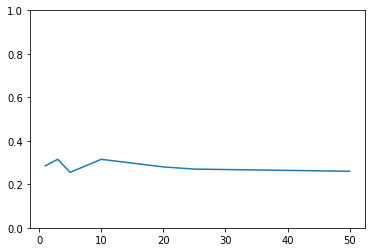

In [195]:
import matplotlib.pyplot as plt
plt.plot(k_vals, list(k2acc.values()))
plt.ylim([0,1])
plt.savefig("accvsk.png", dpi = 600)

In [158]:
r["tokens"][borders[0]:borders[1]]

['available', 'sar', '##s', '-', 'cov', '-', '2']

In [166]:
s = spike_df["sentence_text"].tolist()
spike_df[spike_df["sentence_text"] != data_dev[2]["second"]]

,sentence_id,arg1,arg2,title,article_link,arg1_first_index,arg1_last_index,arg2_first_index,arg2_last_index,sentence_text,paragraph_text
0,2836,human immunodeficiency virus ( HIV ),simian viruses,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,11,16,20,21,Such zoonotic transmissions have caused devast...,"Harvey J. Alter, a Susan L. Stramer, b and Rog..."
1,7383722,The measles virus,rinderpest,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,0,2,11,11,The measles virus evolved from a virus disease...,The measles virus evolved from a virus disease...
2,13495749,"( "" human immunodeficiency virus "" )","SIV ( "" simian immunodeficiency virus "" ) of c...",Systematic Survey of Zoonotic and Sapronotic M...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,1,7,10,28,"HIV-1 ( "" human immunodeficiency virus "" ) evo...",Source of infection (natural host range): man....
3,13628052,The feline infectious peritonitis virus ( FIPV...,feline enteric coronaviruses,Springer Seminars in Immunopathology Immunopat...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,0,8,13,15,The feline infectious peritonitis virus ( FIPV...,Feline coronaviruses comprise multiple strains...
4,13628052,The feline infectious peritonitis virus ( FIPV...,FECV,Springer Seminars in Immunopathology Immunopat...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,0,8,17,17,The feline infectious peritonitis virus ( FIPV...,Feline coronaviruses comprise multiple strains...
5,18107034,measles virus,rinderpest,An Ecological Framework of the Human Virome Pr...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,5,6,14,14,"A more recent example is measles virus , which...",The fact that many pathogenic viruses have cir...
6,21310682,the SARS-CoV-2 virus,the bat SARS-like CoV,CORRESPONDENCE Letter: The Risk of COVID-19 In...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,4,6,10,13,Phylogenetic analysis revealed that the SARS-C...,Phylogenetic analysis revealed that the SARS-C...


In [80]:

sent = train_dataset[0][0]
bert_tokens, orig_to_tok_map, tok_to_orig_map, tokens_tensor = model.tokenize(sent.split(" "))
indexed_tokens = model.tokenizer.convert_tokens_to_ids(bert_tokens)
tokens_tensor = torch.tensor([indexed_tokens])

for d in train_dataset:
    sent = d[0]
    bert_tokens, orig_to_tok_map, tok_to_orig_map, tokens_tensor = model.tokenize(sent.split(" "))
    print(len(bert_tokens))

152
70
93
108
51
116
77
104
90
146
89
89
95
113
127
124
130
84
101
86
56
112
123
65
152
97
103
134
82
131
106
112
104
150
158
72
121
119
87
126
94
141
84
144
70
144
85
84
101
164
75
97
105
95
74
90
82
134
116
116
67
82
94
115
95
121
99
119
90
96
91
90
77
91
135
84
76
109
92
105
132
88
113
80
95
85
87
86
110
101
57
140
94
95
110
82
80
105
82
92
113
151
102
140
107
111
103
129
149
103
71
179
104
79
147
93
117
109
88
115
87
99
92
81
62
102
103
104
101
85
70
96
102
100
86
127
147
127
85
108
93
74
121
65
97
169
183
140
61
76
155
137
87
124
86
136
137
132
89
134
145
95
100
104
144
97
119
101
150
99
94
52
145
149
118
153
72
100
75
70
102
114
158
164
102
122
104
78
132
122
143
132
102
79
73
101
63
91
87
98
70
101
87
111
144
113
99
97
95
102
117
69
139
69
83
91
87
103
175
84
130
109
132
101
69
114
124
175
84
93
81
106
115
128
83
98
90
117
58
94
133
107
91
85
98
97
108
62
74
83
88
134
71
101
99
124
97
97
56
112
161
74
104
63
100
156
87
84
124
86
153
88
76
145
61
111
136
84
89
102
84
125
106
99
1

131
74
94
92
98
97
93
75
106
72
74
99
118
84
120
87
88
77
90
108
92
92
81
86
170
73
78
98
121
95
97
107
76
120
118
91
154
98
62
106
73
90
112
112
92
99
92
97
189
120
98
85
108
51
122
87
119
68
95
101
62
70
87
78
63
55
70
122
78
83
108
84
124
145
51
65
105
78
91
58
83
81
91
61
117
97
99
142
119
100
65
119
82
70
158
108
94
82
98
64
170
111
101
134
108
144
113
157
108
149
81
155
85
82
77
108
71
73
96
91
65
67
101
60
71
89
77
100
86
122
101
91
88
116
130
78
112
54
73
111
83
91
67
82
45
85
69
169
110
69
169
71
77
147
81
68
80
98
112
107
94
111
85
83
63
81
110
81
132
76
77
88
114
77
145
156
74
79
100
65
53
84
78
218
89
97
112
94
92
85
80
89
79
144
119
85
101
175
126
111
126
141
161
100
81
75
79
81
140
96
126
122
112
101
83
76
111
65
66
103
82
144
85
96
120
99
87
113
107
109
125
84
44
87
105
97
135
130
100
99
108
74
119
55
93
130
102
103
96
177
73
145
75
111
190
81
117
110
178
114
70
88
175
90
81
183
56
111
89
96
75
103
116
103
110
94
81
124
75
89
76
72
107
75
94
165
111
117
72
101
109
112
91

KeyboardInterrupt: 

In [ ]:
train_dataset[0][0]

In [ ]:
print(sent)
print(bert_tokens)
print(get_entity_range((1,3), orig_to_tok_map))

In [ ]:
from nltk import ngrams
list(ngrams(range(10), 3))

In [ ]:
q = get_all_ngrams_spans(10, [(3,5)], start_ind = 0, n_max=2)
q

In [ ]:
q[0]

In [ ]:
states = torch.randn(500,300)
ngrams = get_all_ngrams_spans(len(states), [[0,4], [13, 16]], start_ind = 50)
negatives = [states[ngram[0]:ngram[1]].mean(dim=0) for ngram in ngrams]
negatives = torch.stack(negatives)

In [ ]:
negatives.shape, len(ngrams)

In [ ]:
list(range(2,2))

In [ ]:
model.training_step([train_dataset[0]],0)

In [ ]:
train_dataset[0]

In [ ]:
type(torch.zeros(1).item())

In [ ]:
model.linear_adrg1_1.bias[0:1]

In [ ]:
s,idx,l,_ = train_dataset[1]
idx = idx.detach().cpu().numpy()
s.split(" ")[idx[1][0][0]:idx[1][0][1]+1]
print(s.split(" ")[26:])

In [ ]:
bert_tokens, orig_to_tok_map, tok_to_orig_map, tokens_tensor = model.tokenize(s.split(" "))
sent1_range_arg1 = get_entity_range_multiword_expression(idx[0][0], orig_to_tok_map)
sent1_range_arg2 = get_entity_range_multiword_expression(idx[0][1], orig_to_tok_map)
sent2_range_arg1 = get_entity_range_multiword_expression(idx[1][0], orig_to_tok_map)
sent2_range_arg2 = get_entity_range_multiword_expression(idx[1][1], orig_to_tok_map)
l_tokens = orig_to_tok_map[l]

In [ ]:
sent2_range_arg1
bert_tokens_2 = bert_tokens[l_tokens:]
bert_tokens_2[sent2_range_arg1[0]-l_tokens:sent2_range_arg1[1]-l_tokens]

In [ ]:
l_tokens

In [ ]:
AutoModel.from_pretrained('Shauli/RE-metric-model-spike')

In [ ]:
config = AutoConfig.from_pretrained('Shauli/IE-metric-model-spike', output_hidden_states=True)
model = AutoModel.from_pretrained('Shauli/RE-metric-model-spike', config=config)  

In [ ]:
config = AutoConfig.from_pretrained('Shauli/IE-metric-model-spike', output_hidden_states=True)

In [ ]:
train_dataset[0]

In [177]:
data_dev[0]

{'first': 'Interestingly , <<ARG1:ANDV>> may also be shed by {{ARG2:humans}} through other biological fluids such as urine [ 136 ] , illustrating the particular properties that differentiate this virus from other hantaviruses .',
 'second': 'Our blood is a valuable reservoir of energy ; the female vector feeds on our blood to aliment its eggs and the microorganism feeds on blood cells to fuel its frantic meiosis .',
 'second_with_arguments': 'Our {{ARG2:blood>> is a valuable reservoir of <<ARG1:energy}} ; the female vector feeds on our blood to aliment its eggs and the microorganism feeds on blood cells to fuel its frantic meiosis .',
 'query_first': '<E|U+C>arg2:[e=ORGANISM|ORGANISM_SUBSTANCE]bats $[l]shed <E|U+C>arg1:[e=ORGANISM|ORGANISM_SUBSTANCE|ORGANISM_SUBDIVISION]COVID-19',
 'query_second': '<E|U+C>arg2:[e]bats are a $reservoir $of <E|U+C>arg1:[e]something',
 'first_arg1': (2, 2),
 'first_arg2': (8, 8),
 'second_arg1': (7, 7),
 'second_arg2': (1, 1),
 'first_arg1_words': ['human